In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

#path = "/Volumes/ROHIT/SURE Data/AllDealMinuteData.csv"
path = "/Users/rohitk/Documents/AllDealMinuteDataNew.csv"

#Deals listed as Cash/Stock/Hybrid (ACQ,TAR) Rumor(Y/N)= 

#Deals:

#(AMZN,WFM) Cash No Rumor
#(FIS,WP) Hybrid No Rumor 
#(HRS,LLL) Stock No Rumor
#(IBM,RHT) Cash No Rumor 
#(MSFT,LNKD) Cash Yes Rumor
#(OXY,APC) Hybrid Yes Rumor
#(PFE,ARRY) Cash No Rumor
#(SXL, ETP) Stock No Rumor
#(TMUS, S) Stock Yes Rumor
#(UTX,COL) Hybrid Yes Rumor
#(ADI,LLTC) Hybrid No Rumor
#(D,SCG) Stock No Rumor
#(WMB,WPZ) Stock No Rumor
#(AVGO,CA) Cash Yes Rumor
#(FISV,FDC) Stock No Rumor

In [2]:
from stargazer.stargazer import Stargazer
from IPython.core.display import Latex
from IPython.core.display import HTML

In [3]:
df = pd.read_csv(path)

In [4]:
df.columns

Index(['Minutes', 'DATE', 'Time', 'Datetime', 'PRICE', 'dollar', 'midpoint',
       'wEffectiveSpread_Dollar', 'NBO', 'NBB', 'logPrice', 'returns',
       'Volatility', 'DayVolatility', 'Announced', 'AorT', 'Ticker',
       'QuotedSpread', 'timeNum', 'logVolume', 'TradeVolume',
       'logDayVolatility', 'logOfSpread', 'DayReturns', 'DailyLogOfSpread',
       'DailyLogPrice', 'DailyLogVolume', 'DailySpread', 'DailyPrice',
       'DailyDollarVolume', 'DailyLogDollarVolume', 'DailyDollarVolume.1',
       'DailyShareVolume', 'DailyLogShareVolume'],
      dtype='object')

In [6]:
df = df[df['QuotedSpread'] > 0]

In [7]:
df['timeNum'] = df['Time'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]) - 570)
df['logVolume'] = np.log(np.exp(df['dollar']) / df['PRICE'])
df['TradeVolume'] = np.exp(df['dollar']) / df['PRICE']
df['logDayVolatility'] = np.log(df['DayVolatility'])
df['logSpread'] = np.log(df['QuotedSpread'])

In [5]:
#ACQ vs TArgets and remove first 5 and last 5 trading minutes
dfACQ = df[(df['AorT'] == 1) & (df['timeNum'] >= 5) & (df['timeNum'] <= 385)]
dfTAR = df[(df['AorT'] == 0) & (df['timeNum'] >= 5) & (df['timeNum'] <= 385)] 

#TAR and ACQ before and after announcement
dfTARAfter = dfTAR[dfTAR['Announced'] == 1]
dfTARBefore = dfTAR[dfTAR['Announced'] == 0]
dfACQAfter = dfACQ[dfACQ['Announced'] == 1]
dfACQBefore = dfACQ[dfACQ['Announced'] == 0]

In [6]:
dfCashTAR = df[(df['Ticker'] == 'WFM') | (df['Ticker'] == 'RHT') | (df['Ticker'] == 'LNKD') | (df['Ticker'] == 'ARRY') | (df['Ticker'] == 'CA')]
dfHybridTAR = df[(df['Ticker'] == 'WP') | (df['Ticker'] == 'APC') | (df['Ticker'] == 'COL') | (df['Ticker'] == 'LLTC')]
dfStockTAR = df[(df['Ticker'] == 'LLL') | (df['Ticker'] == 'ETP') | (df['Ticker'] == 'S') | (df['Ticker'] == 'WPZ') | (df['Ticker'] == 'FDC')| (df['Ticker'] == 'SCG')]

In [7]:
dfCashACQ = df[(df['Ticker'] == 'AMZN') | (df['Ticker'] == 'IBM') | (df['Ticker'] == 'MSFT') | (df['Ticker'] == 'PFE') | (df['Ticker'] == 'AVGO')]
dfHybridACQ = df[(df['Ticker'] == 'FIS') | (df['Ticker'] == 'OXY') | (df['Ticker'] == 'UTX') | (df['Ticker'] == 'ADI')]
dfStockACQ = df[(df['Ticker'] == 'HRS') | (df['Ticker'] == 'SXL') | (df['Ticker'] == 'TMUS') | (df['Ticker'] == 'WMB') | (df['Ticker'] == 'FISV')| (df['Ticker'] == 'D')]

In [8]:
dfTARGroupDate = dfTAR.groupby(['Ticker','Datetime']).mean()
dfACQGroupDate = dfACQ.groupby(['Ticker','Datetime']).mean()

In [9]:
dfTARGroupDate.index.levels[-1].astype('str')
dfACQGroupDate.index.levels[-1].astype('str')

Index(['2016-05-02 09:35:00', '2016-05-02 09:36:00', '2016-05-02 09:37:00',
       '2016-05-02 09:38:00', '2016-05-02 09:39:00', '2016-05-02 09:40:00',
       '2016-05-02 09:41:00', '2016-05-02 09:42:00', '2016-05-02 09:43:00',
       '2016-05-02 09:44:00',
       ...
       '2019-07-31 15:46:00', '2019-07-31 15:47:00', '2019-07-31 15:48:00',
       '2019-07-31 15:49:00', '2019-07-31 15:50:00', '2019-07-31 15:51:00',
       '2019-07-31 15:52:00', '2019-07-31 15:53:00', '2019-07-31 15:54:00',
       '2019-07-31 15:55:00'],
      dtype='object', name='Datetime', length=261663)

In [10]:
AMZN_DT_Arr = dfACQGroupDate.xs('AMZN').index.to_numpy()
WFM_DT_Arr = dfTARGroupDate.xs('WFM').index.to_numpy()
AMZN_DT = np.where(AMZN_DT_Arr == '2017-06-16 09:36:00')[0][0]
WFM_DT = np.where(WFM_DT_Arr == '2017-06-16 09:50:00')[0][0]

FIS_DT_Arr = dfACQGroupDate.xs('FIS').index.to_numpy()
WP_DT_Arr = dfTARGroupDate.xs('WP').index.to_numpy()
FIS_DT = np.where(FIS_DT_Arr == '2019-03-18 09:36:00')[0][0]
WP_DT = np.where(WP_DT_Arr == '2019-03-18 09:36:00')[0][0]

HRS_DT_Arr = dfACQGroupDate.xs('HRS').index.to_numpy()
LLL_DT_Arr = dfTARGroupDate.xs('LLL').index.to_numpy()
HRS_DT = np.where(HRS_DT_Arr == '2018-10-15 09:36:00')[0][0]
LLL_DT = np.where(LLL_DT_Arr == '2018-10-15 09:36:00')[0][0]

IBM_DT_Arr = dfACQGroupDate.xs('IBM').index.to_numpy()
RHT_DT_Arr = dfTARGroupDate.xs('RHT').index.to_numpy()
IBM_DT = np.where(IBM_DT_Arr == '2018-10-29 09:36:00')[0][0]
RHT_DT = np.where(RHT_DT_Arr == '2018-10-29 09:36:00')[0][0]

MSFT_DT_Arr = dfACQGroupDate.xs('MSFT').index.to_numpy()
LNKD_DT_Arr = dfTARGroupDate.xs('LNKD').index.to_numpy()
MSFT_DT = np.where(MSFT_DT_Arr == '2016-06-13 09:36:00')[0][0]
LNKD_DT = np.where(LNKD_DT_Arr == '2016-06-13 09:36:00')[0][0]

OXY_DT_Arr = dfACQGroupDate.xs('OXY').index.to_numpy()
APC_DT_Arr = dfTARGroupDate.xs('APC').index.to_numpy()
OXY_DT = np.where(OXY_DT_Arr == '2019-04-24 09:36:00')[0][0]
APC_DT = np.where(APC_DT_Arr == '2019-04-24 09:36:00')[0][0]

PFE_DT_Arr = dfACQGroupDate.xs('PFE').index.to_numpy()
ARRY_DT_Arr = dfTARGroupDate.xs('ARRY').index.to_numpy()
PFE_DT = np.where(PFE_DT_Arr == '2019-06-17 09:36:00')[0][0]
ARRY_DT = np.where(ARRY_DT_Arr == '2019-06-17 09:36:00')[0][0]

SXL_DT_Arr = dfACQGroupDate.xs('SXL').index.to_numpy()
ETP_DT_Arr = dfTARGroupDate.xs('ETP').index.to_numpy()
SXL_DT = np.where(SXL_DT_Arr == '2016-11-21 09:36:00')[0][0]
ETP_DT = np.where(ETP_DT_Arr == '2016-11-21 09:36:00')[0][0]

TMUS_DT_Arr = dfACQGroupDate.xs('TMUS').index.to_numpy()
S_DT_Arr = dfTARGroupDate.xs('S').index.to_numpy()
TMUS_DT = np.where(TMUS_DT_Arr == '2018-04-30 09:36:00')[0][0]
S_DT = np.where(S_DT_Arr == '2018-04-30 09:36:00')[0][0]

UTX_DT_Arr = dfACQGroupDate.xs('UTX').index.to_numpy()
COL_DT_Arr = dfTARGroupDate.xs('COL').index.to_numpy()
UTX_DT = np.where(UTX_DT_Arr == '2017-09-05 09:36:00')[0][0] #correct for labour day
COL_DT = np.where(COL_DT_Arr == '2017-09-05 09:36:00')[0][0] #correct for labour day

ADI_DT_Arr = dfACQGroupDate.xs('ADI').index.to_numpy()
LLTC_DT_Arr = dfTARGroupDate.xs('LLTC').index.to_numpy()
ADI_DT = np.where(ADI_DT_Arr == '2016-07-26 09:36:00')[0][0]
LLTC_DT = np.where(LLTC_DT_Arr == '2016-07-26 09:36:00')[0][0]

D_DT_Arr = dfACQGroupDate.xs('D').index.to_numpy()
SCG_DT_Arr = dfTARGroupDate.xs('SCG').index.to_numpy()
D_DT = np.where(D_DT_Arr == '2018-01-03 09:36:00')[0][0]
SCG_DT = np.where(SCG_DT_Arr == '2018-01-03 09:36:00')[0][0]

WMB_DT_Arr = dfACQGroupDate.xs('WMB').index.to_numpy()
WPZ_DT_Arr = dfTARGroupDate.xs('WPZ').index.to_numpy()
WMB_DT = np.where(WMB_DT_Arr == '2018-05-17 09:36:00')[0][0]
WPZ_DT = np.where(WPZ_DT_Arr == '2018-05-17 09:36:00')[0][0]

AVGO_DT_Arr = dfACQGroupDate.xs('AVGO').index.to_numpy()
CA_DT_Arr = dfTARGroupDate.xs('CA').index.to_numpy()
AVGO_DT = np.where(AVGO_DT_Arr == '2018-07-12 09:36:00')[0][0] #overnight adjustment
CA_DT = np.where(CA_DT_Arr == '2018-07-12 09:36:00')[0][0] #overnight adjustment

FISV_DT_Arr = dfACQGroupDate.xs('FISV').index.to_numpy()
FDC_DT_Arr = dfTARGroupDate.xs('FDC').index.to_numpy()
FISV_DT = np.where(FISV_DT_Arr == '2019-01-16 09:36:00')[0][0]
FDC_DT = np.where(FDC_DT_Arr == '2019-01-16 09:36:00')[0][0]

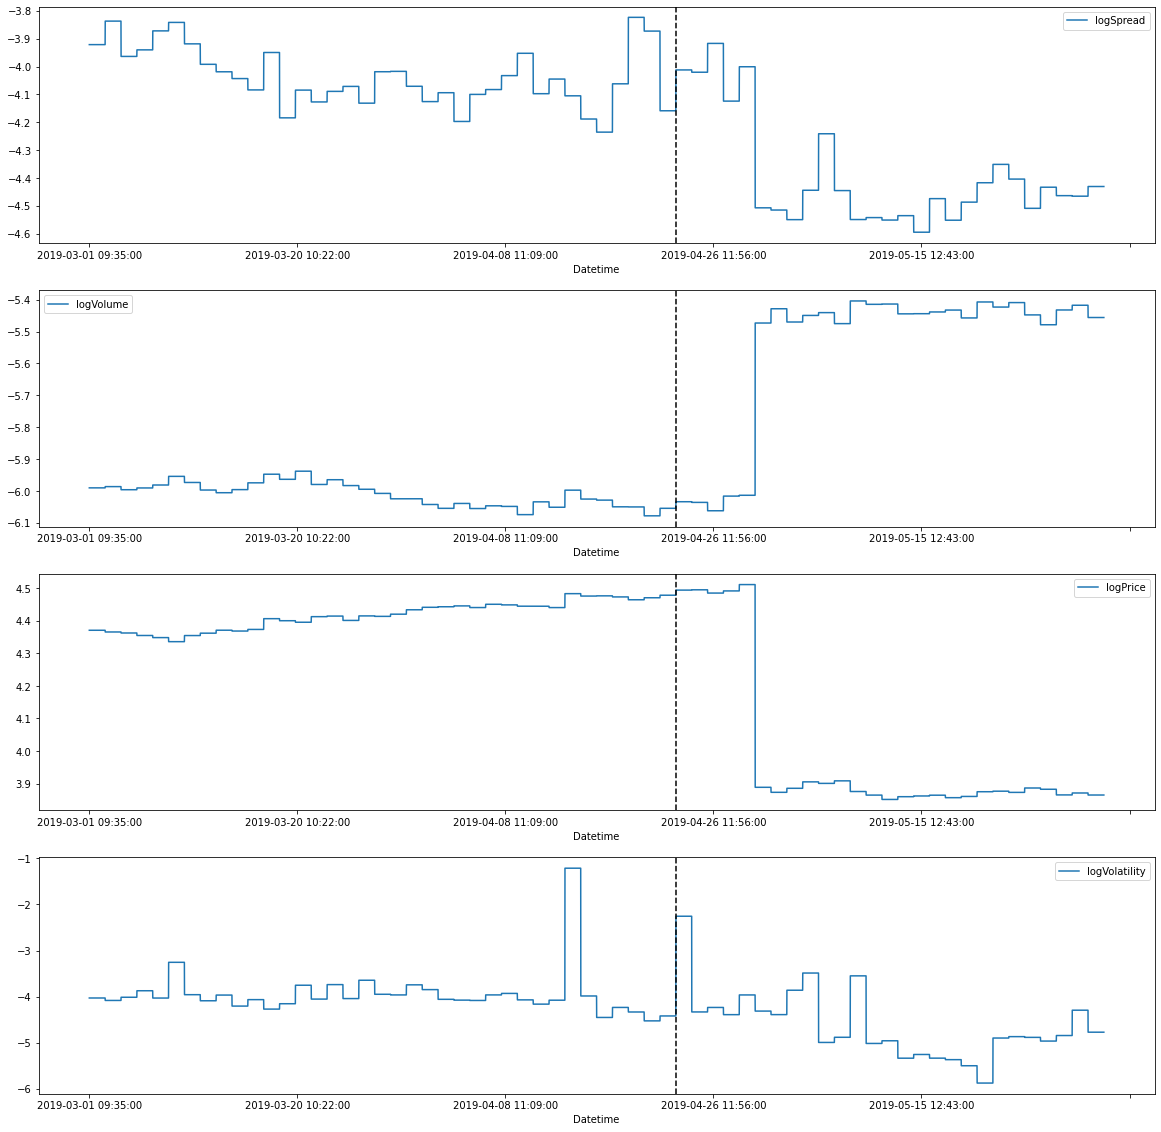

In [11]:
# Hybrid + Rumor 
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroupDate.xs('APC').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread')
a[0].axvline(APC_DT, color='k', linestyle='--')
dfTARGroupDate.xs('APC').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume')
a[1].axvline(APC_DT, color='k', linestyle='--')
dfTARGroupDate.xs('APC').plot(y='DailyLogPrice',ax=a[2],label='logPrice')
a[2].axvline(APC_DT, color='k', linestyle='--')
dfTARGroupDate.xs('APC').plot(y='logDayVolatility',ax=a[3],label='logVolatility')
a[3].axvline(APC_DT, color='k', linestyle='--')

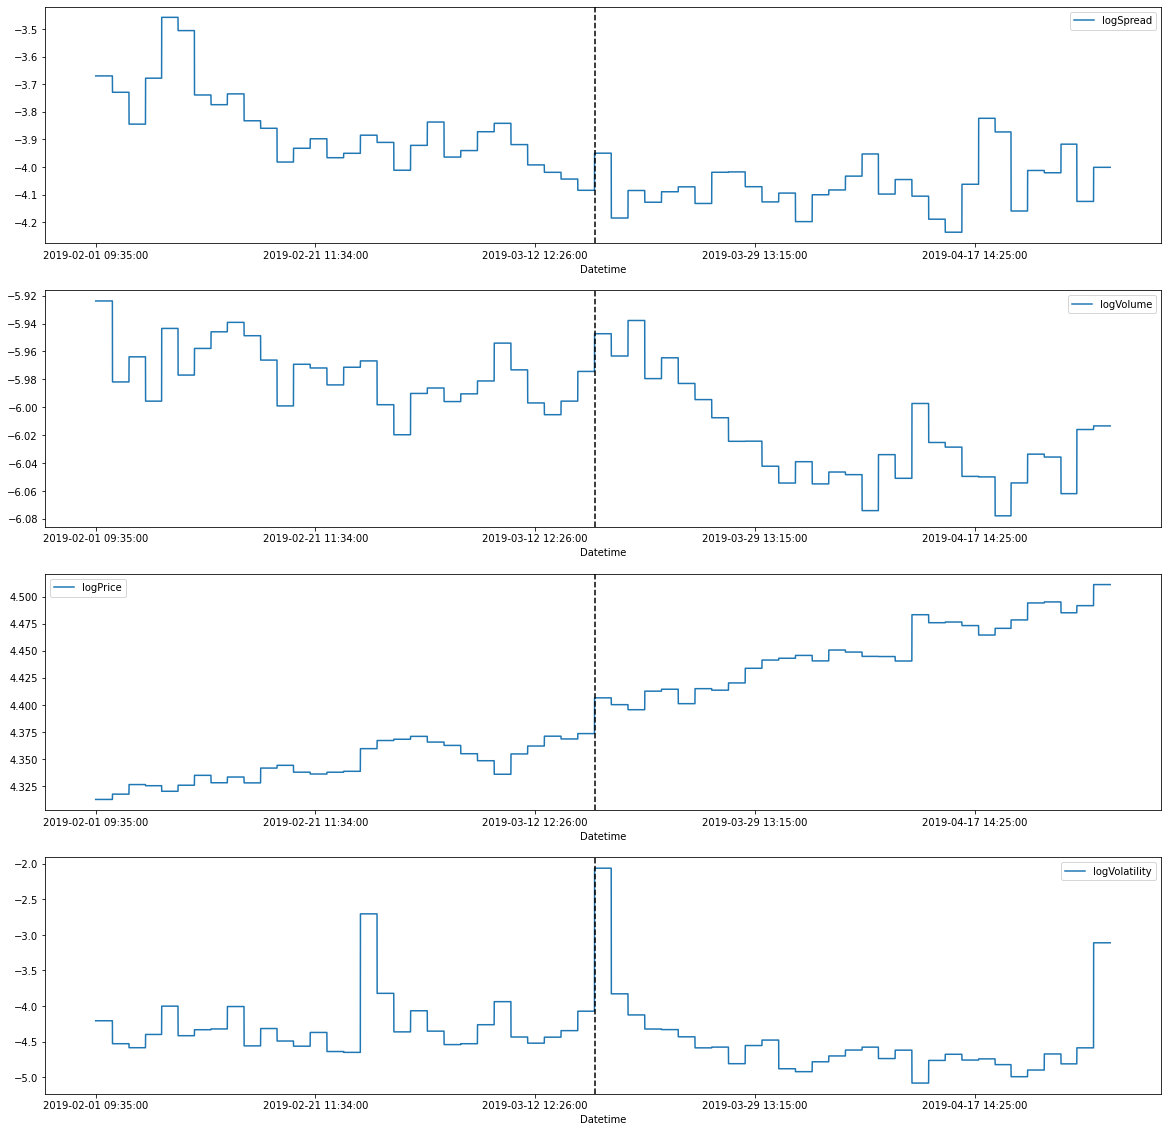

In [12]:
#Hybrid deal
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroupDate.xs('WP').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread')
a[0].axvline(WP_DT, color='k', linestyle='--')
dfTARGroupDate.xs('WP').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume')
a[1].axvline(WP_DT, color='k', linestyle='--')
dfTARGroupDate.xs('WP').plot(y='DailyLogPrice',ax=a[2],label='logPrice')
a[2].axvline(WP_DT, color='k', linestyle='--')
dfTARGroupDate.xs('WP').plot(y='logDayVolatility',ax=a[3],label='logVolatility')
a[3].axvline(WP_DT, color='k', linestyle='--')

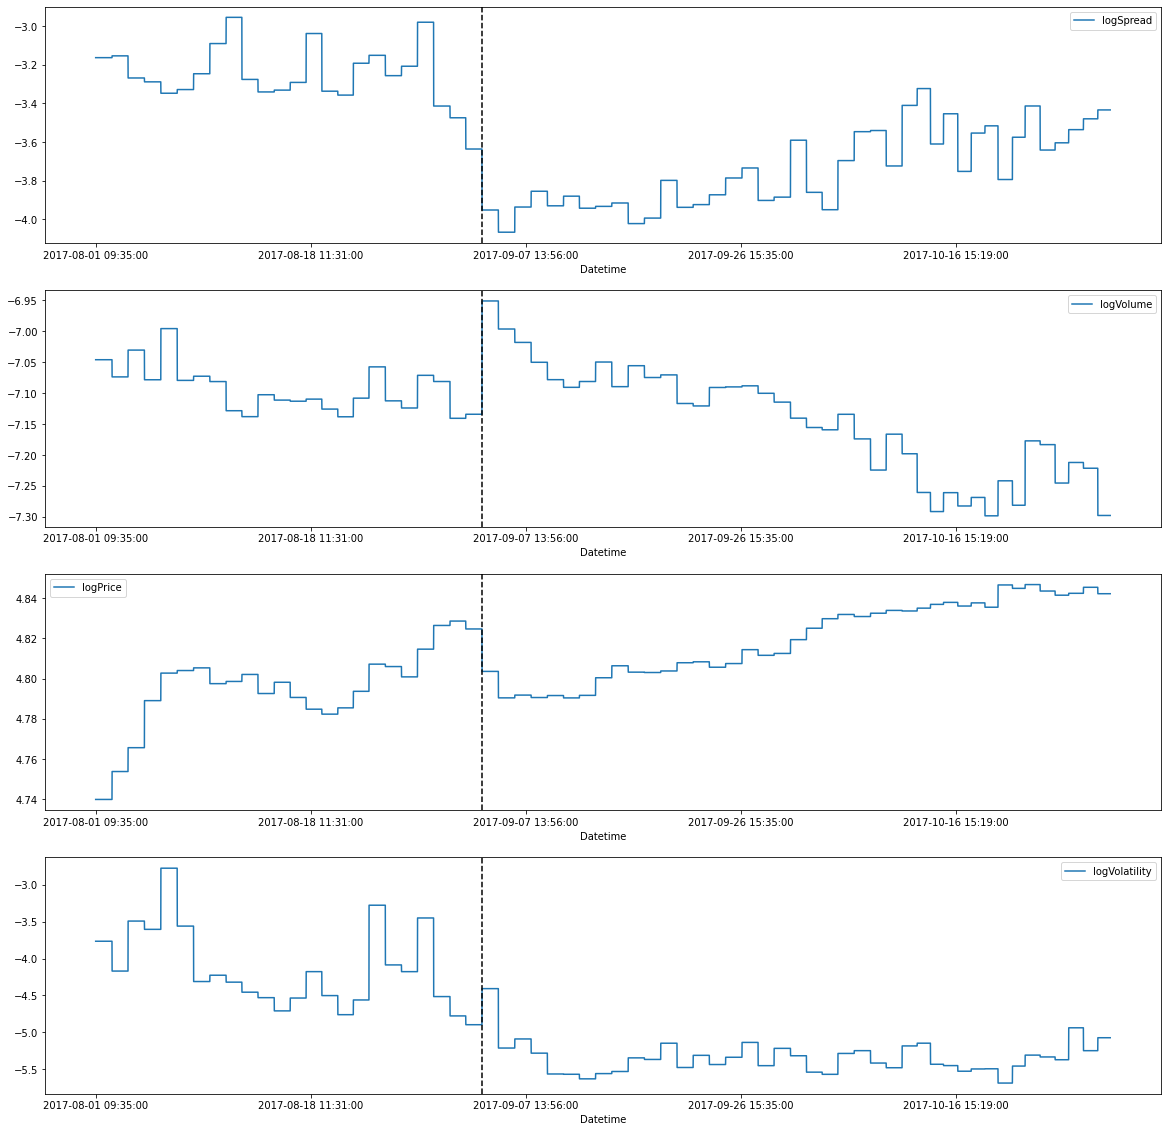

In [13]:
#Hybrid + Rumor
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroupDate.xs('COL').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread')
a[0].axvline(COL_DT, color='k', linestyle='--')
dfTARGroupDate.xs('COL').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume')
a[1].axvline(COL_DT, color='k', linestyle='--')
dfTARGroupDate.xs('COL').plot(y='DailyLogPrice',ax=a[2],label='logPrice')
a[2].axvline(COL_DT, color='k', linestyle='--')
dfTARGroupDate.xs('COL').plot(y='logDayVolatility',ax=a[3],label='logVolatility')
a[3].axvline(COL_DT, color='k', linestyle='--')

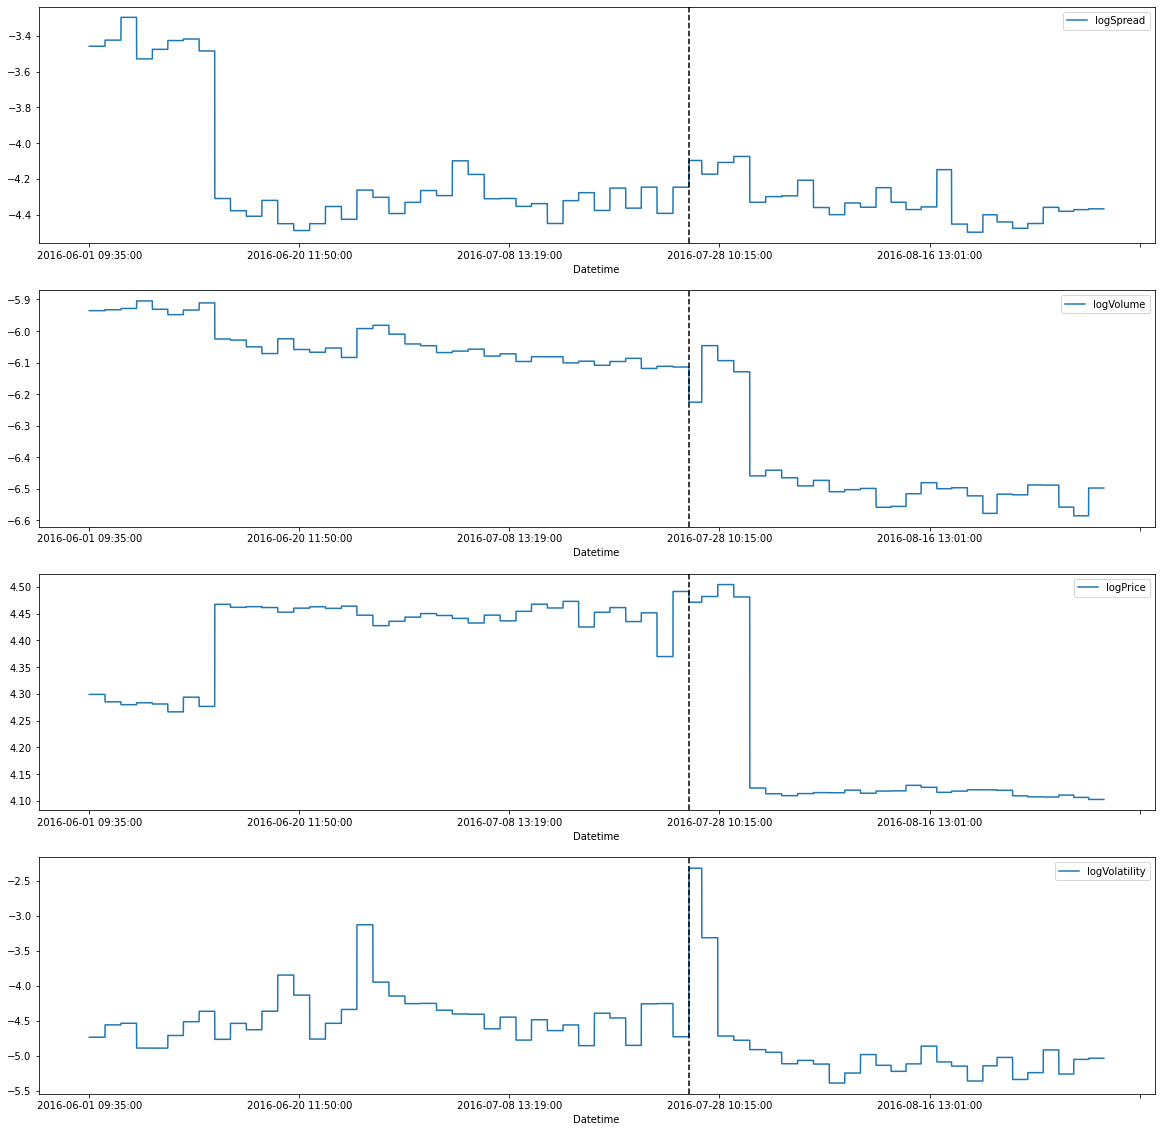

In [14]:
#Hybrid
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroupDate.xs('LLTC').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread')
a[0].axvline(LLTC_DT, color='k', linestyle='--')
dfTARGroupDate.xs('LLTC').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume')
a[1].axvline(LLTC_DT, color='k', linestyle='--')
dfTARGroupDate.xs('LLTC').plot(y='DailyLogPrice',ax=a[2],label='logPrice')
a[2].axvline(LLTC_DT, color='k', linestyle='--')
dfTARGroupDate.xs('LLTC').plot(y='logDayVolatility',ax=a[3],label='logVolatility')
a[3].axvline(LLTC_DT, color='k', linestyle='--')

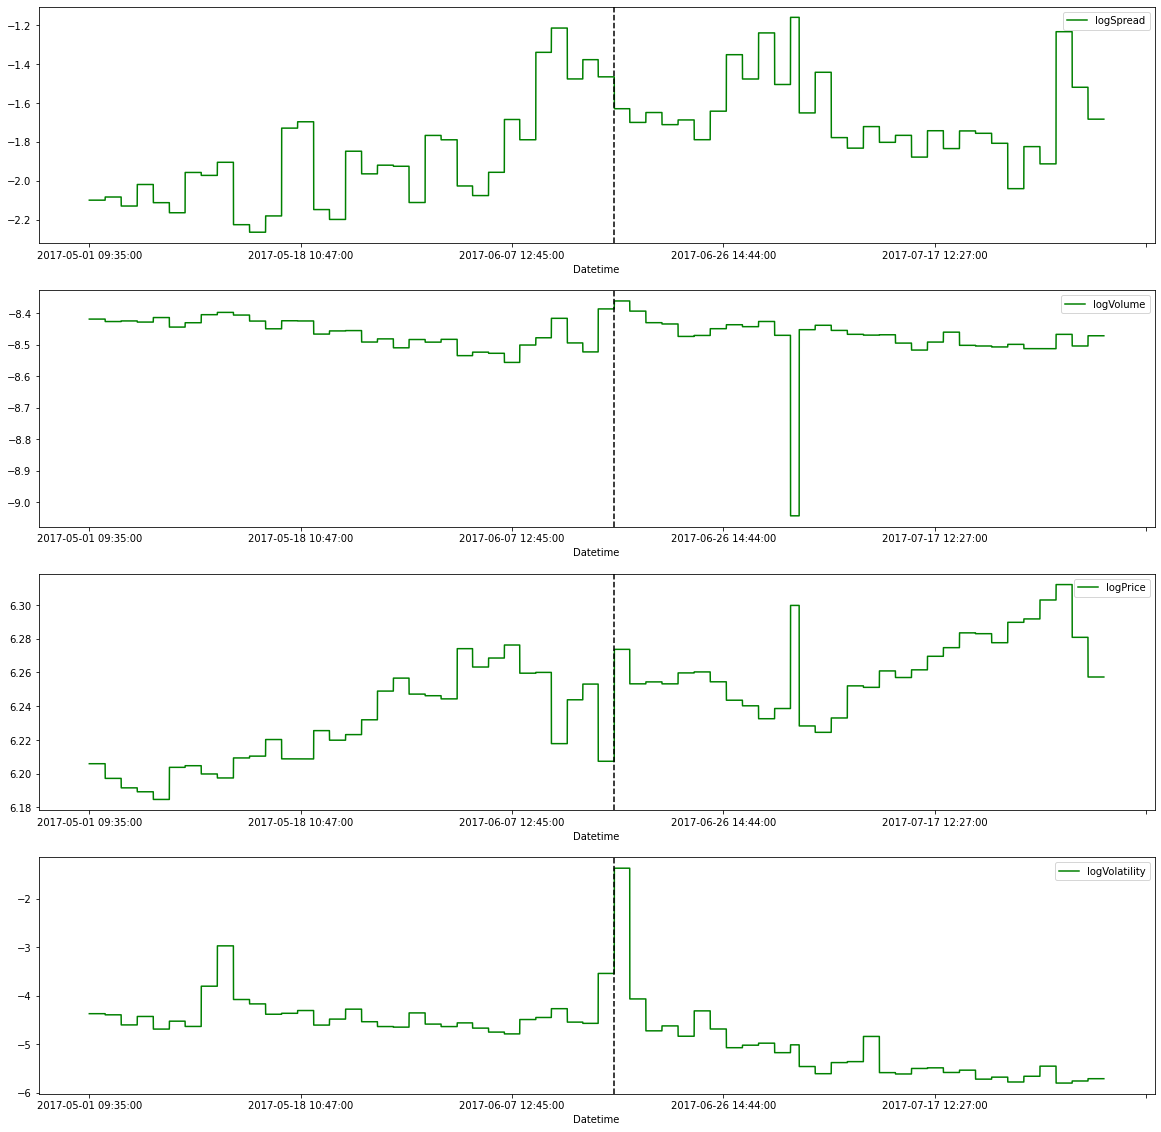

In [15]:
#Cash
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroupDate.xs('WFM').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread',color='g')
a[0].axvline(WFM_DT, color='k', linestyle='--')
dfTARGroupDate.xs('WFM').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume',color='g')
a[1].axvline(WFM_DT, color='k', linestyle='--')
dfTARGroupDate.xs('WFM').plot(y='DailyLogPrice',ax=a[2],label='logPrice',color='g')
a[2].axvline(WFM_DT, color='k', linestyle='--')
dfTARGroupDate.xs('WFM').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='g')
a[3].axvline(WFM_DT, color='k', linestyle='--')

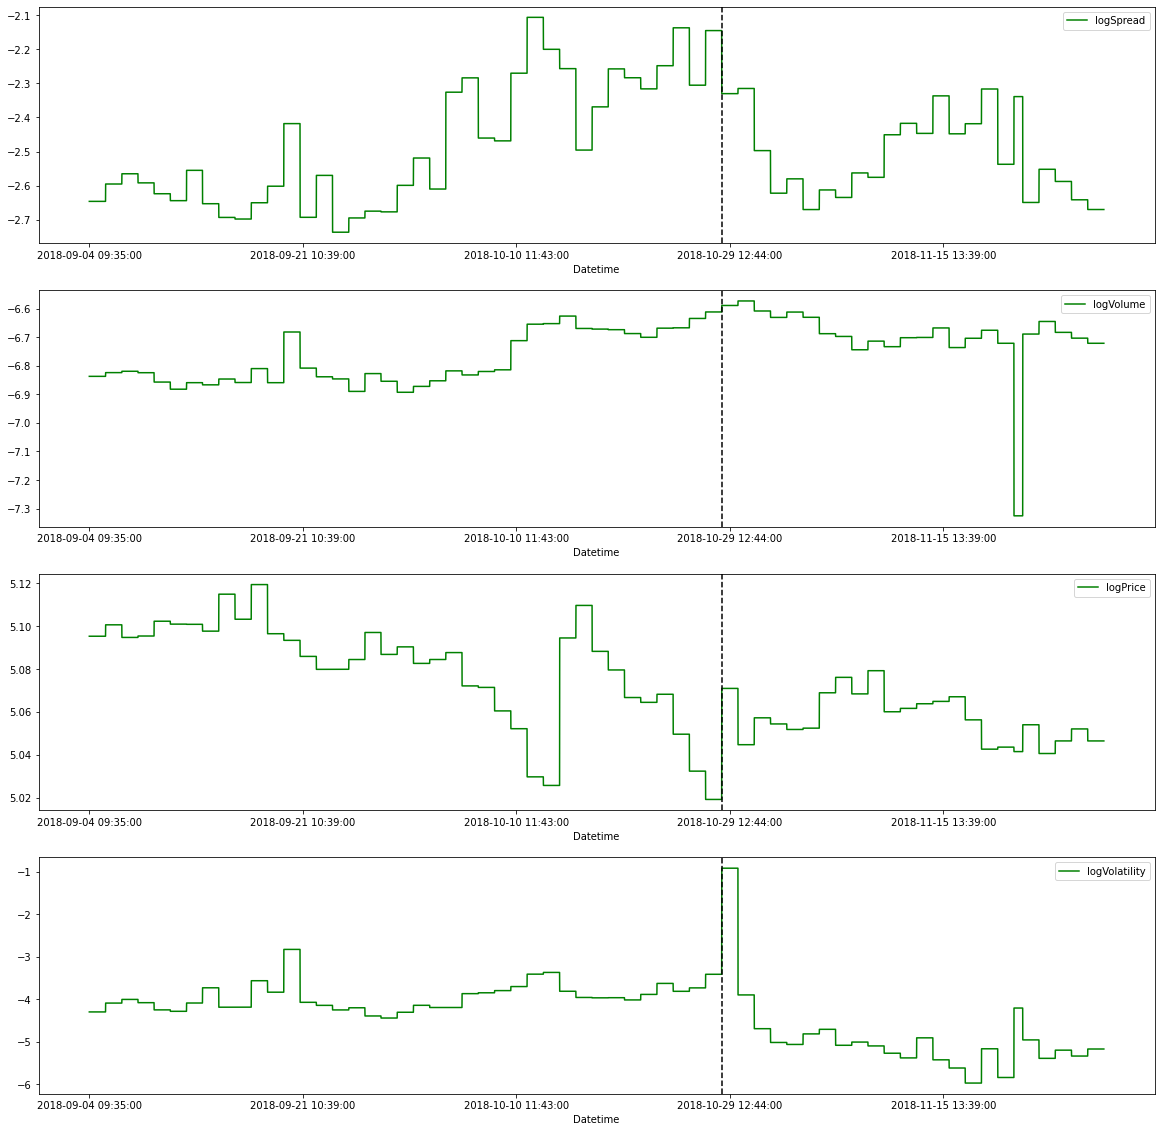

In [16]:
#Cash
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroupDate.xs('RHT').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread',color='g')
a[0].axvline(RHT_DT, color='k', linestyle='--')
dfTARGroupDate.xs('RHT').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume',color='g')
a[1].axvline(RHT_DT, color='k', linestyle='--')
dfTARGroupDate.xs('RHT').plot(y='DailyLogPrice',ax=a[2],label='logPrice',color='g')
a[2].axvline(RHT_DT, color='k', linestyle='--')
dfTARGroupDate.xs('RHT').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='g')
a[3].axvline(RHT_DT, color='k', linestyle='--')

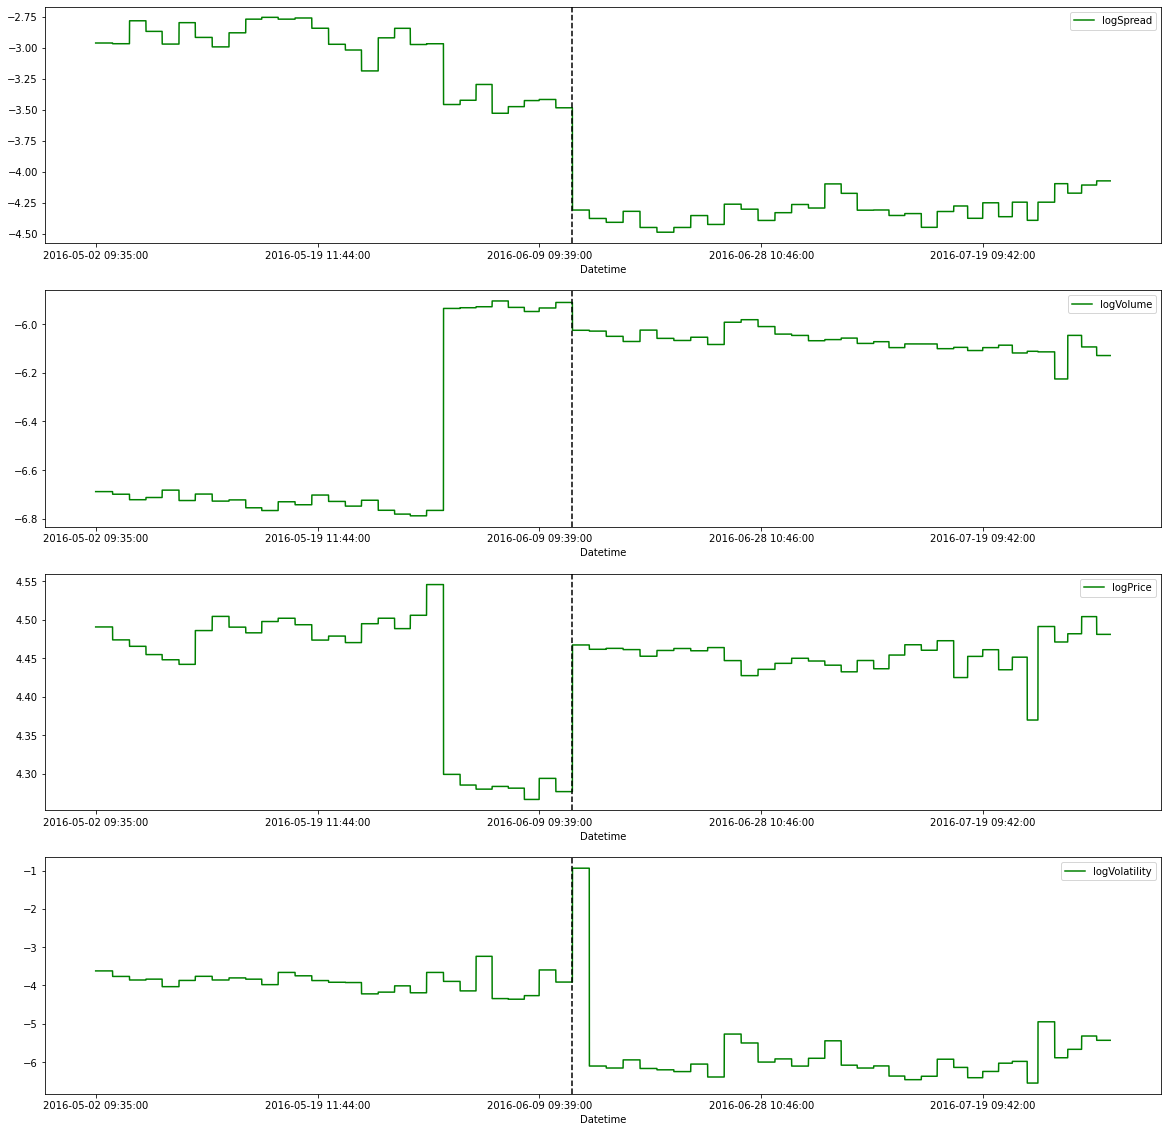

In [17]:
#Cash
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroupDate.xs('LNKD').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread',color='g')
a[0].axvline(LNKD_DT, color='k', linestyle='--')
dfTARGroupDate.xs('LNKD').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume',color='g')
a[1].axvline(LNKD_DT, color='k', linestyle='--')
dfTARGroupDate.xs('LNKD').plot(y='DailyLogPrice',ax=a[2],label='logPrice',color='g')
a[2].axvline(LNKD_DT, color='k', linestyle='--')
dfTARGroupDate.xs('LNKD').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='g')
a[3].axvline(LNKD_DT, color='k', linestyle='--')

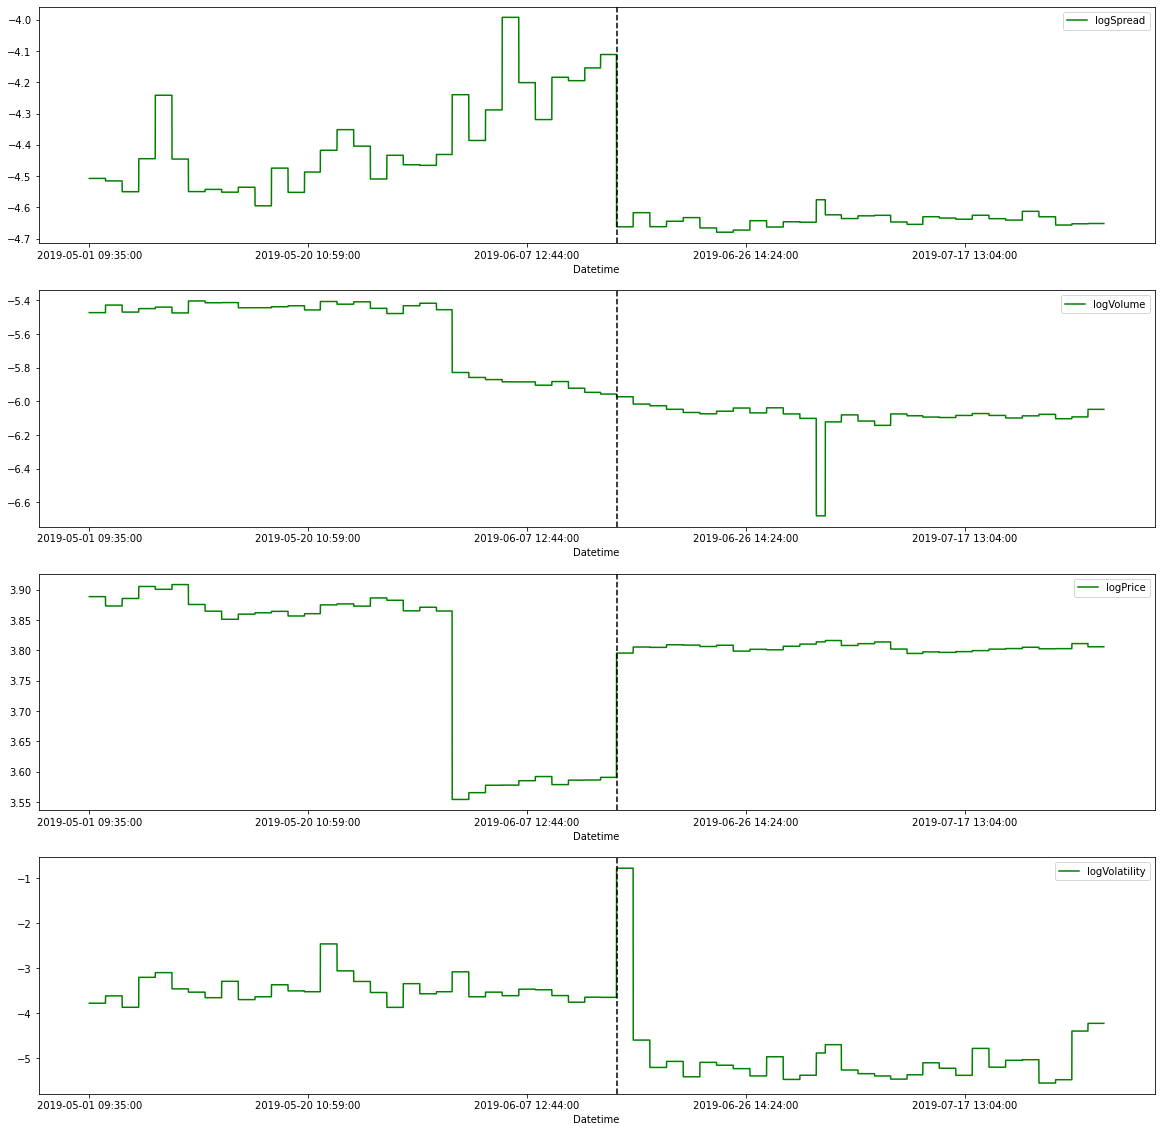

In [18]:
#Cash
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroupDate.xs('ARRY').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread',color='g')
a[0].axvline(ARRY_DT, color='k', linestyle='--')
dfTARGroupDate.xs('ARRY').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume',color='g')
a[1].axvline(ARRY_DT, color='k', linestyle='--')
dfTARGroupDate.xs('ARRY').plot(y='DailyLogPrice',ax=a[2],label='logPrice',color='g')
a[2].axvline(ARRY_DT, color='k', linestyle='--')
dfTARGroupDate.xs('ARRY').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='g')
a[3].axvline(ARRY_DT, color='k', linestyle='--')

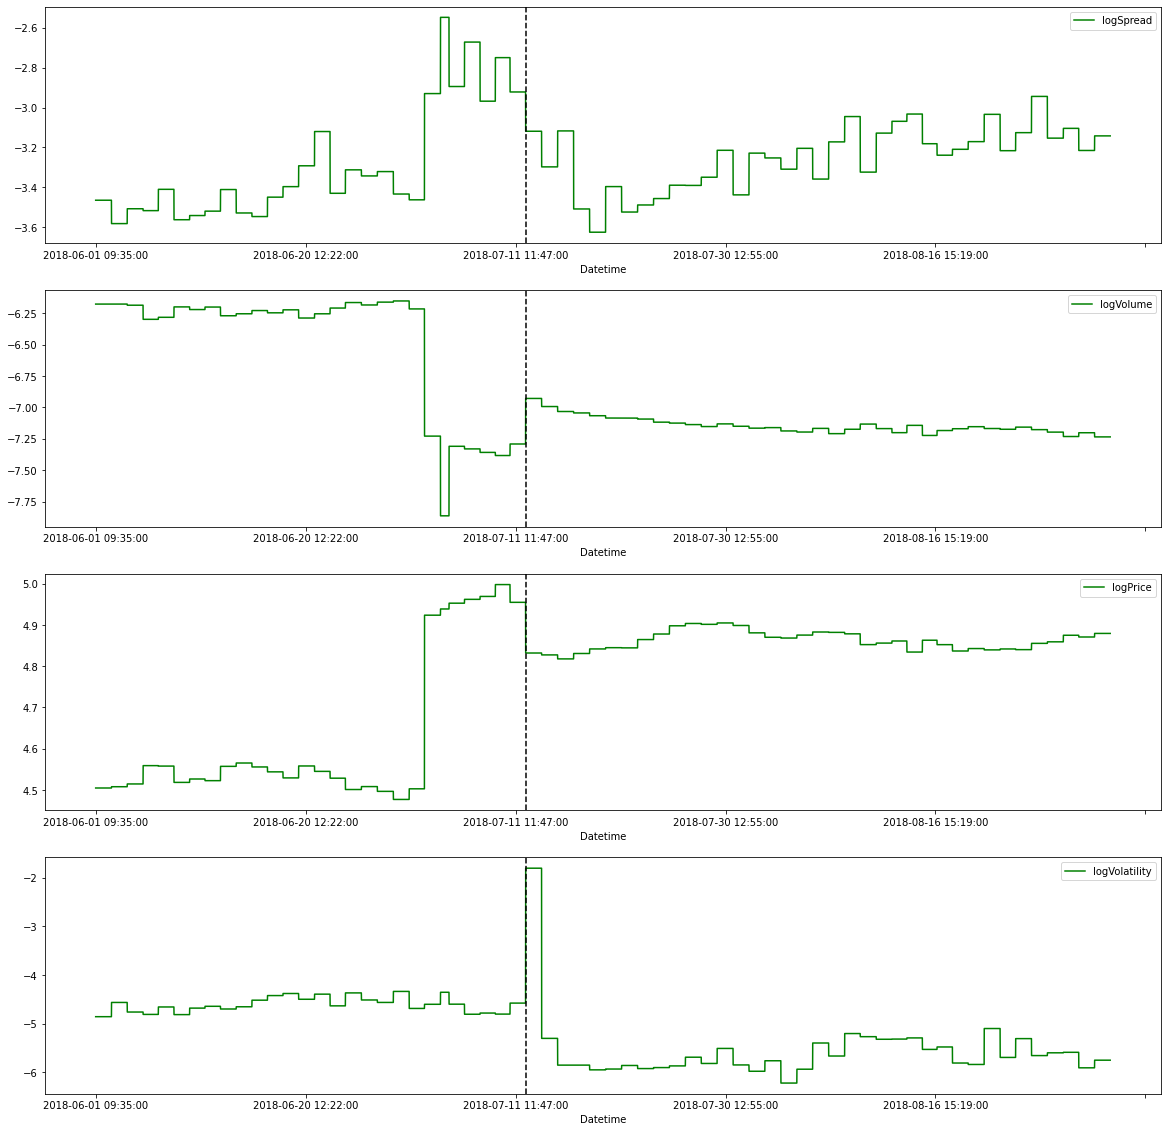

In [19]:
#Cash + Rumor
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroupDate.xs('CA').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread',color='g')
a[0].axvline(CA_DT, color='k', linestyle='--')
dfTARGroupDate.xs('CA').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume',color='g')
a[1].axvline(CA_DT, color='k', linestyle='--')
dfTARGroupDate.xs('CA').plot(y='DailyLogPrice',ax=a[2],label='logPrice',color='g')
a[2].axvline(CA_DT, color='k', linestyle='--')
dfTARGroupDate.xs('CA').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='g')
a[3].axvline(CA_DT, color='k', linestyle='--')

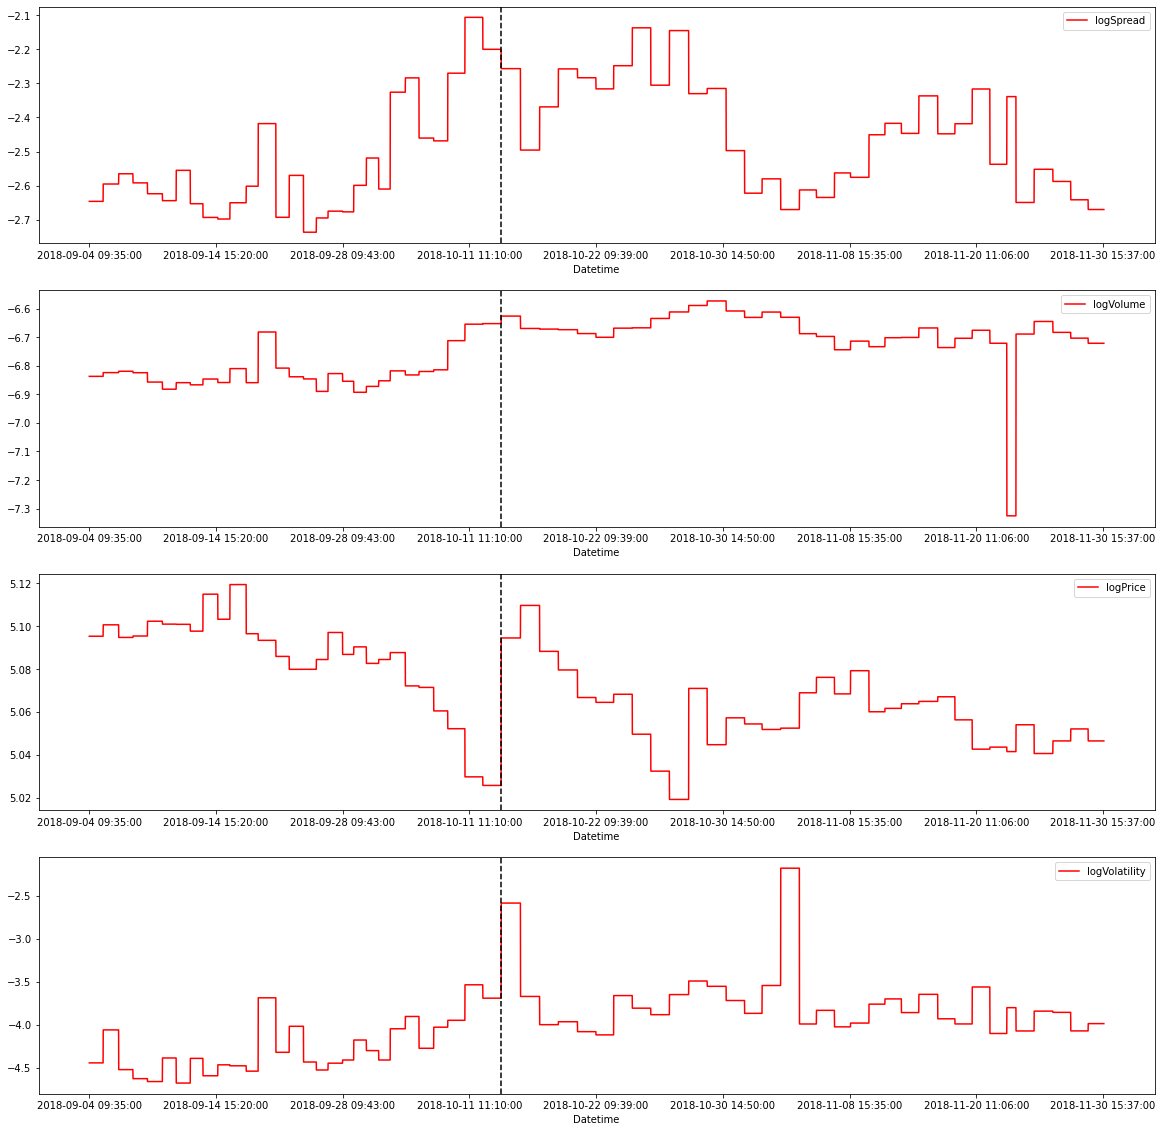

In [20]:
#Stock 
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroupDate.xs('LLL').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread',color='r')
a[0].axvline(LLL_DT, color='k', linestyle='--')
dfTARGroupDate.xs('LLL').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume',color='r')
a[1].axvline(LLL_DT, color='k', linestyle='--')
dfTARGroupDate.xs('LLL').plot(y='DailyLogPrice',ax=a[2],label='logPrice',color='r')
a[2].axvline(LLL_DT, color='k', linestyle='--')
dfTARGroupDate.xs('LLL').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='r')
a[3].axvline(LLL_DT, color='k', linestyle='--')

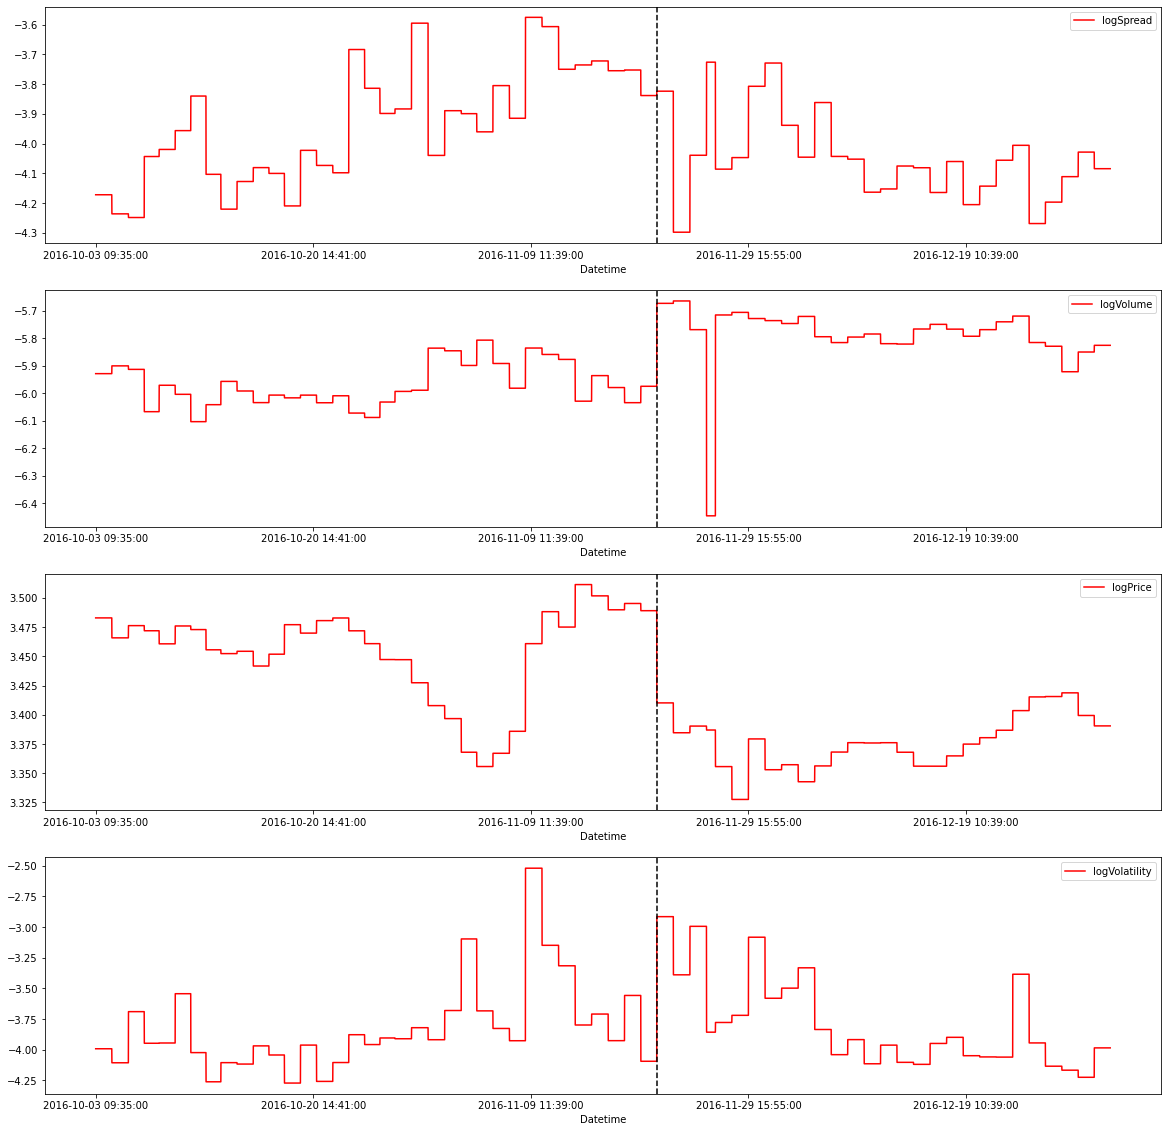

In [21]:
#Stock 
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroupDate.xs('ETP').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread',color='r')
a[0].axvline(ETP_DT, color='k', linestyle='--')
dfTARGroupDate.xs('ETP').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume',color='r')
a[1].axvline(ETP_DT, color='k', linestyle='--')
dfTARGroupDate.xs('ETP').plot(y='DailyLogPrice',ax=a[2],label='logPrice',color='r')
a[2].axvline(ETP_DT, color='k', linestyle='--')
dfTARGroupDate.xs('ETP').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='r')
a[3].axvline(ETP_DT, color='k', linestyle='--')

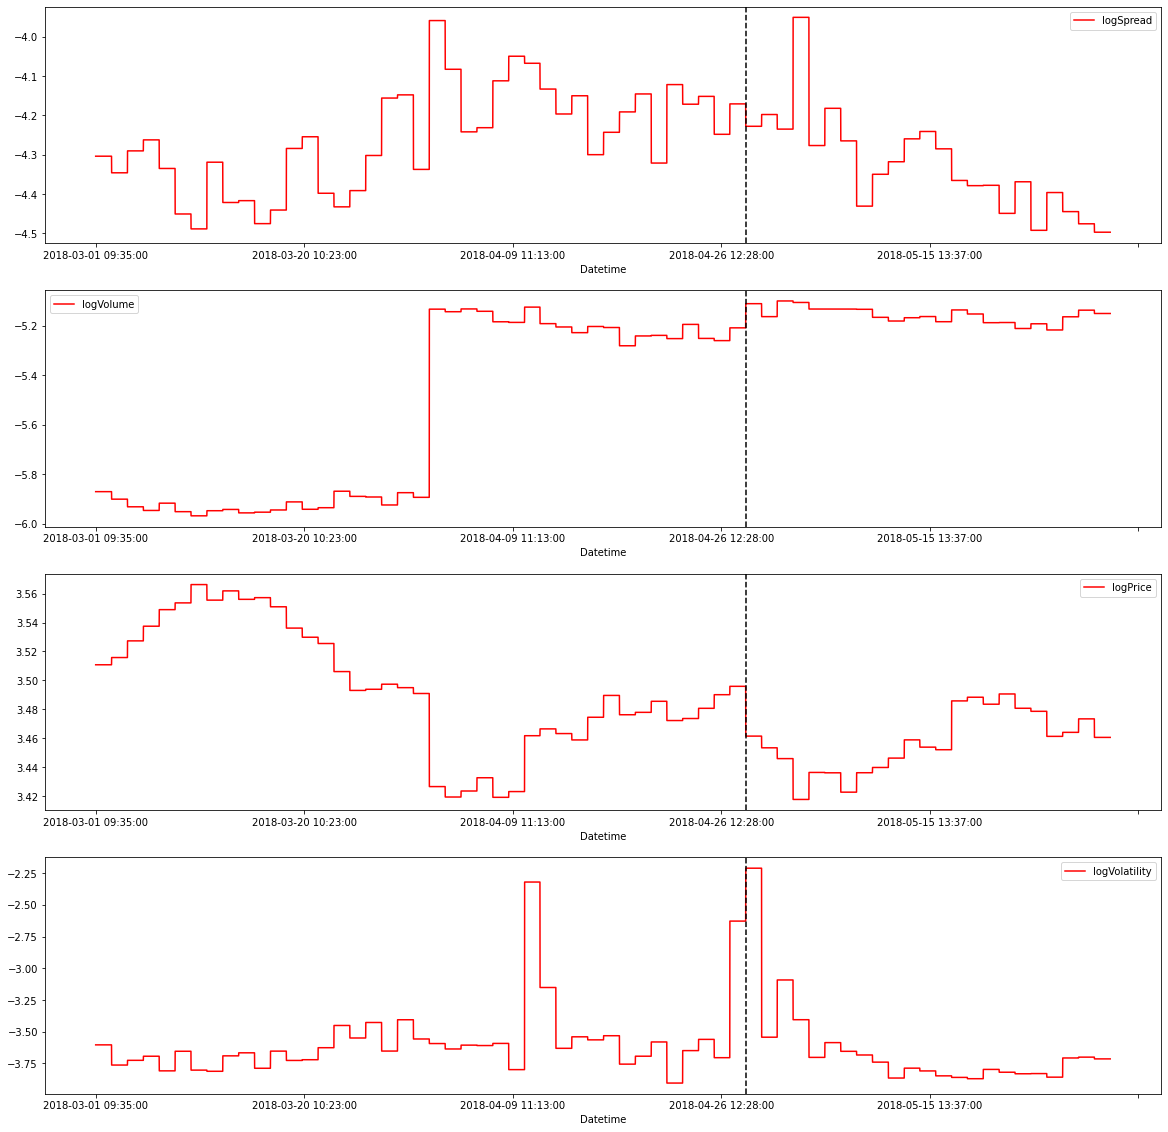

In [22]:
#Stock + Rumor
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroupDate.xs('S').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread',color='r')
a[0].axvline(S_DT, color='k', linestyle='--')
dfTARGroupDate.xs('S').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume',color='r')
a[1].axvline(S_DT, color='k', linestyle='--')
dfTARGroupDate.xs('S').plot(y='DailyLogPrice',ax=a[2],label='logPrice',color='r')
a[2].axvline(S_DT, color='k', linestyle='--')
dfTARGroupDate.xs('S').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='r')
a[3].axvline(S_DT, color='k', linestyle='--')

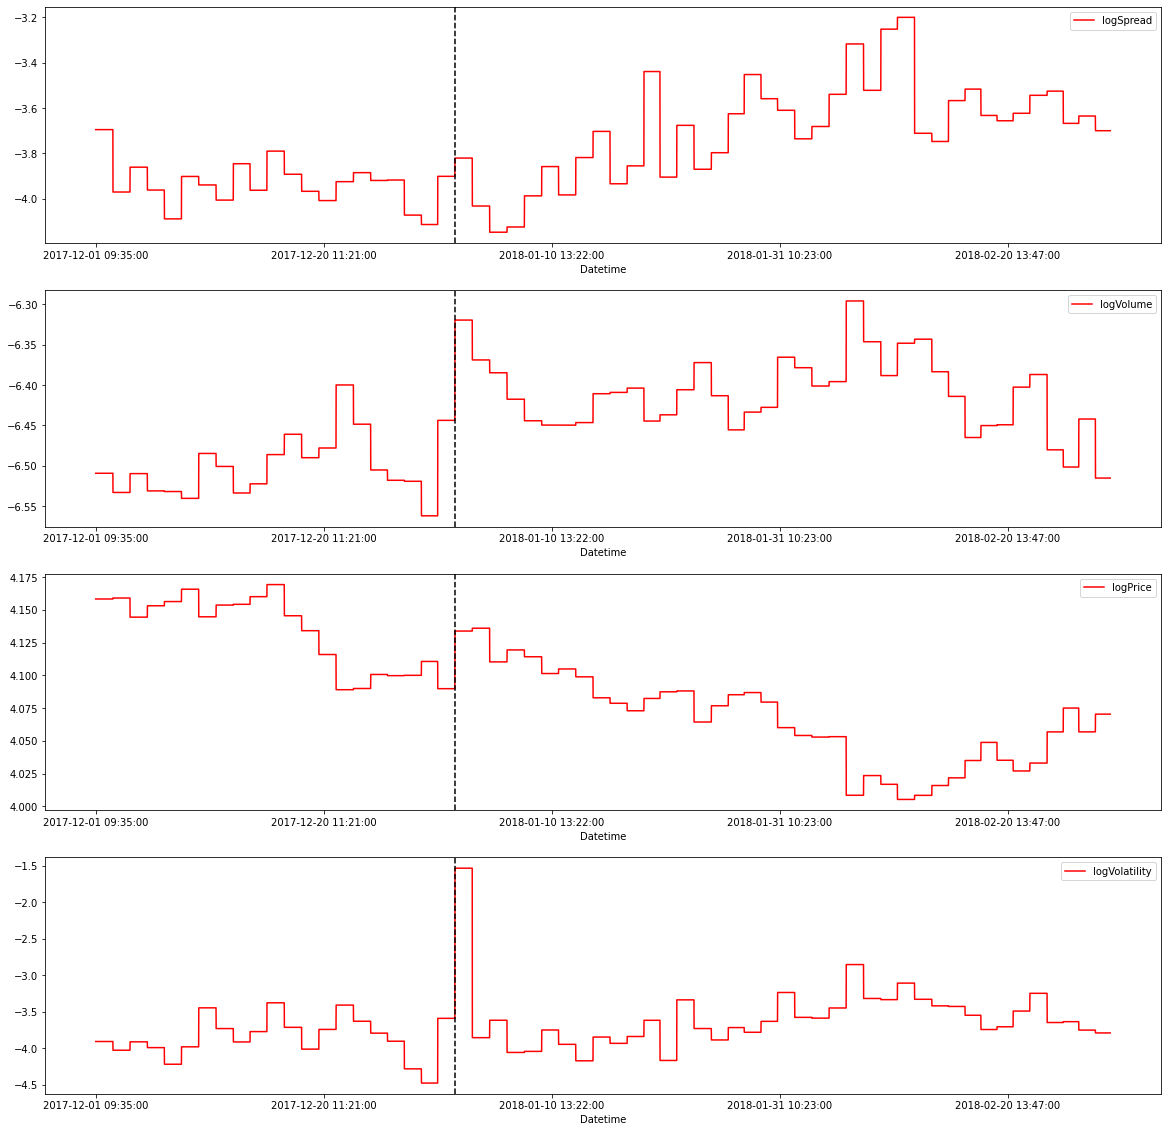

In [23]:
#Stock
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroupDate.xs('SCG').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread',color='r')
a[0].axvline(SCG_DT, color='k', linestyle='--')
dfTARGroupDate.xs('SCG').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume',color='r')
a[1].axvline(SCG_DT, color='k', linestyle='--')
dfTARGroupDate.xs('SCG').plot(y='DailyLogPrice',ax=a[2],label='logPrice',color='r')
a[2].axvline(SCG_DT, color='k', linestyle='--')
dfTARGroupDate.xs('SCG').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='r')
a[3].axvline(SCG_DT, color='k', linestyle='--')

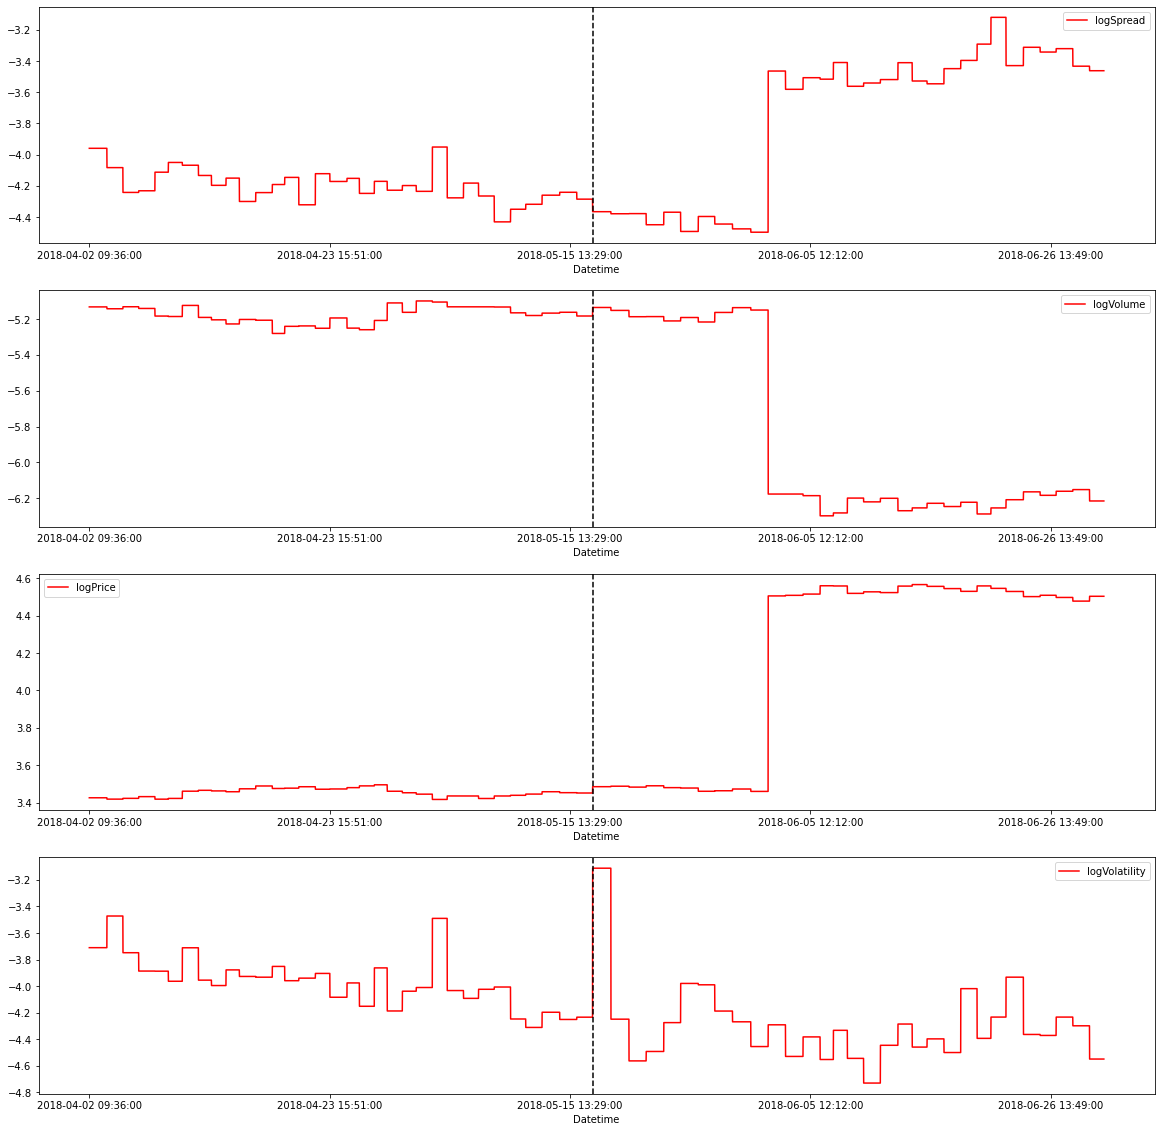

In [24]:
#Stock
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroupDate.xs('WPZ').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread',color='r')
a[0].axvline(WPZ_DT, color='k', linestyle='--')
dfTARGroupDate.xs('WPZ').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume',color='r')
a[1].axvline(WPZ_DT, color='k', linestyle='--')
dfTARGroupDate.xs('WPZ').plot(y='DailyLogPrice',ax=a[2],label='logPrice',color='r')
a[2].axvline(WPZ_DT, color='k', linestyle='--')
dfTARGroupDate.xs('WPZ').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='r')
a[3].axvline(WPZ_DT, color='k', linestyle='--')

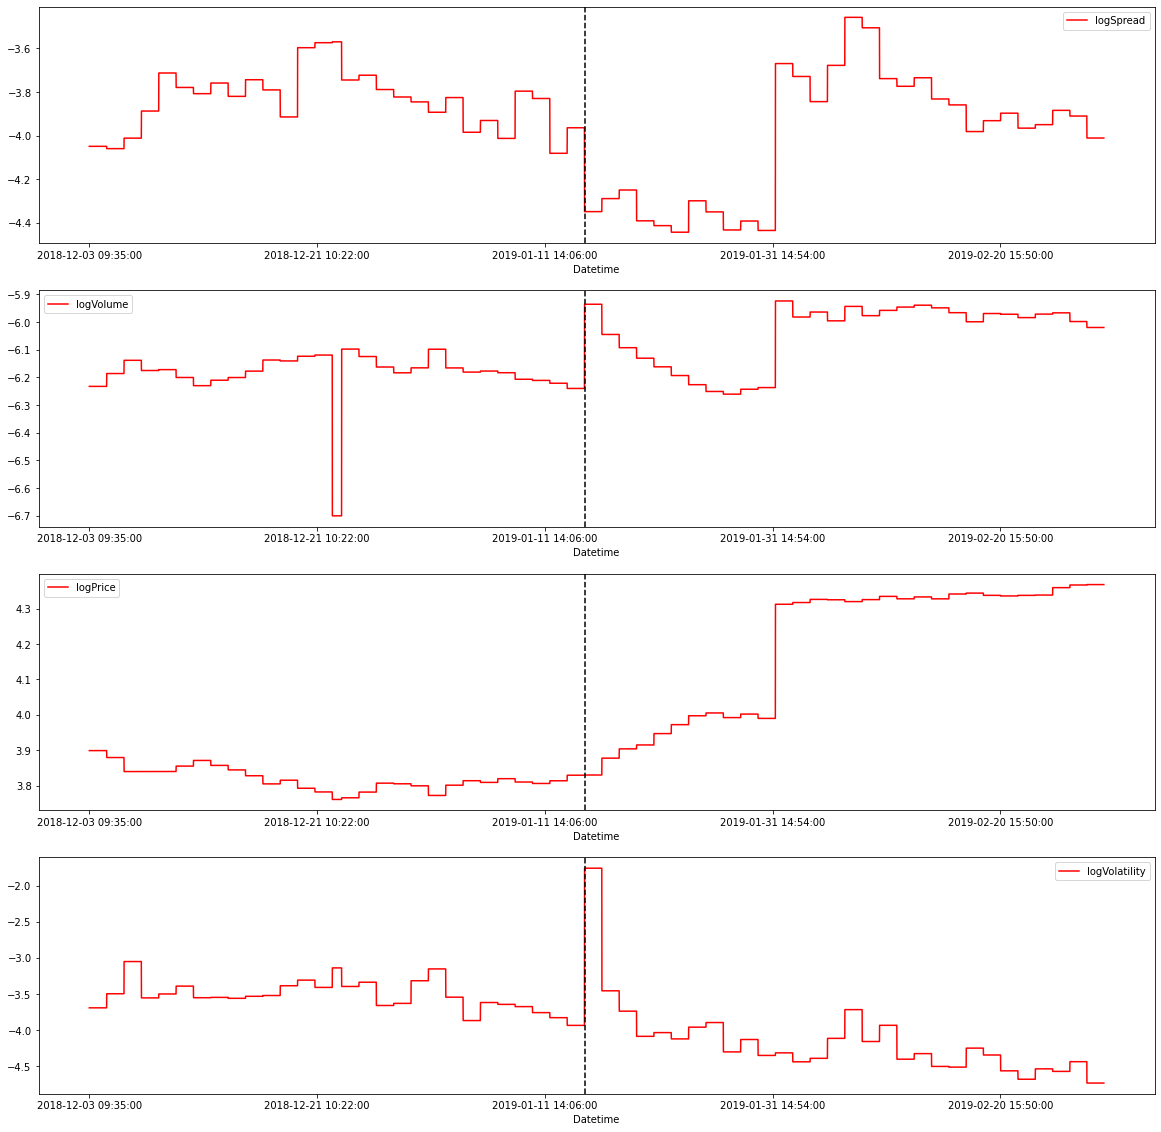

In [25]:
#Stock
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroupDate.xs('FDC').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread',color='r')
a[0].axvline(FDC_DT, color='k', linestyle='--')
dfTARGroupDate.xs('FDC').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume',color='r')
a[1].axvline(FDC_DT, color='k', linestyle='--')
dfTARGroupDate.xs('FDC').plot(y='DailyLogPrice',ax=a[2],label='logPrice',color='r')
a[2].axvline(FDC_DT, color='k', linestyle='--')
dfTARGroupDate.xs('FDC').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='r')
a[3].axvline(FDC_DT, color='k', linestyle='--')

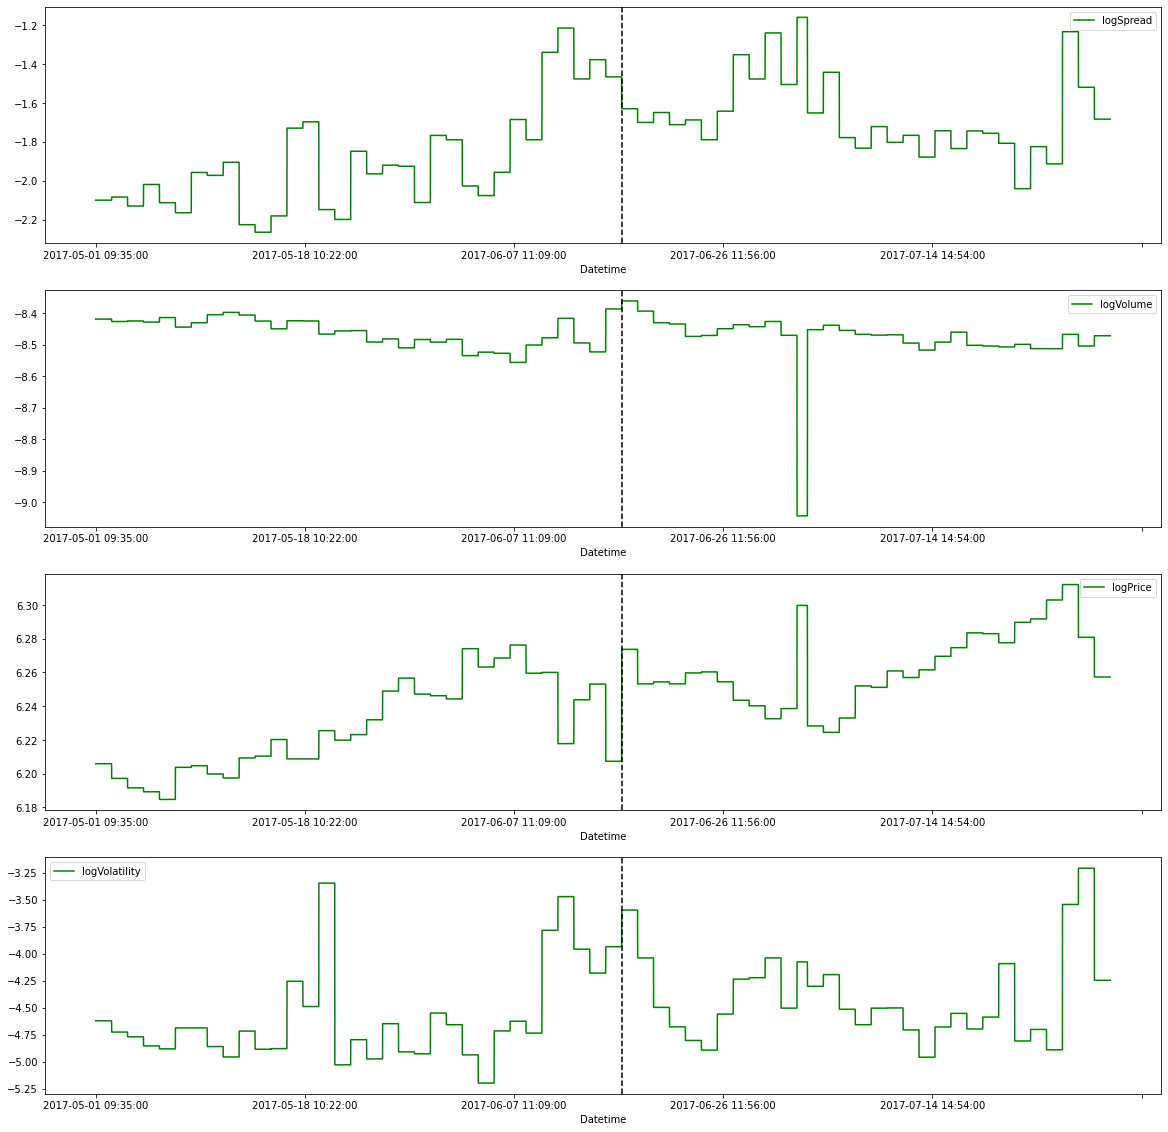

In [26]:
# Cash ACQ
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroupDate.xs('AMZN').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread',color='g')
a[0].axvline(AMZN_DT, color='k', linestyle='--')
dfACQGroupDate.xs('AMZN').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume',color='g')
a[1].axvline(AMZN_DT, color='k', linestyle='--')
dfACQGroupDate.xs('AMZN').plot(y='DailyLogPrice',ax=a[2],label='logPrice',color='g')
a[2].axvline(AMZN_DT, color='k', linestyle='--')
dfACQGroupDate.xs('AMZN').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='g')
a[3].axvline(AMZN_DT, color='k', linestyle='--')

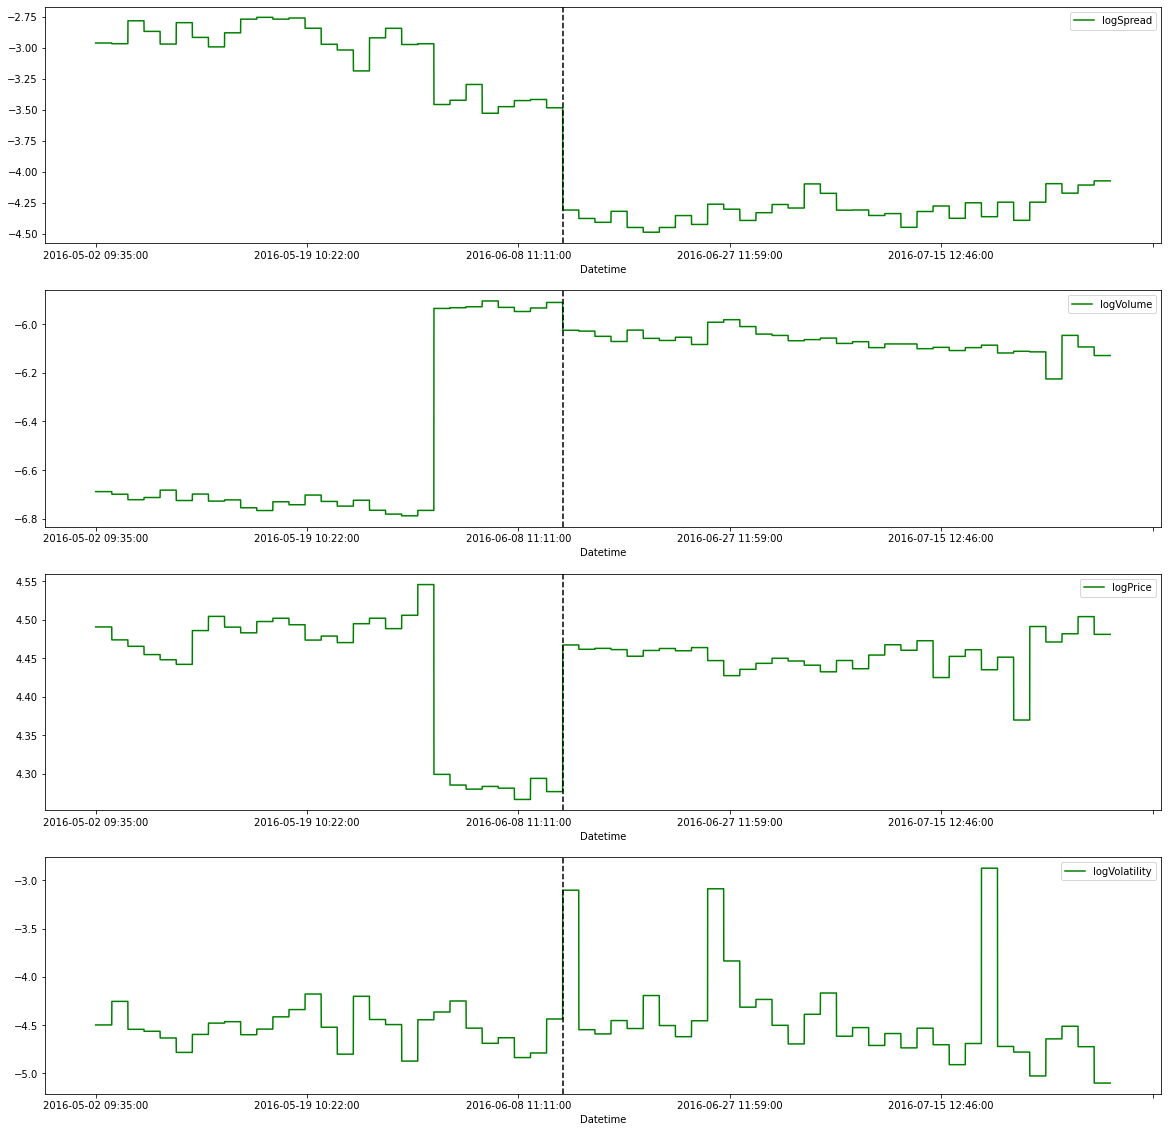

In [27]:
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroupDate.xs('MSFT').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread',color='g')
a[0].axvline(MSFT_DT, color='k', linestyle='--')
dfACQGroupDate.xs('MSFT').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume',color='g')
a[1].axvline(MSFT_DT, color='k', linestyle='--')
dfACQGroupDate.xs('MSFT').plot(y='DailyLogPrice',ax=a[2],label='logPrice',color='g')
a[2].axvline(MSFT_DT, color='k', linestyle='--')
dfACQGroupDate.xs('MSFT').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='g')
a[3].axvline(MSFT_DT, color='k', linestyle='--')

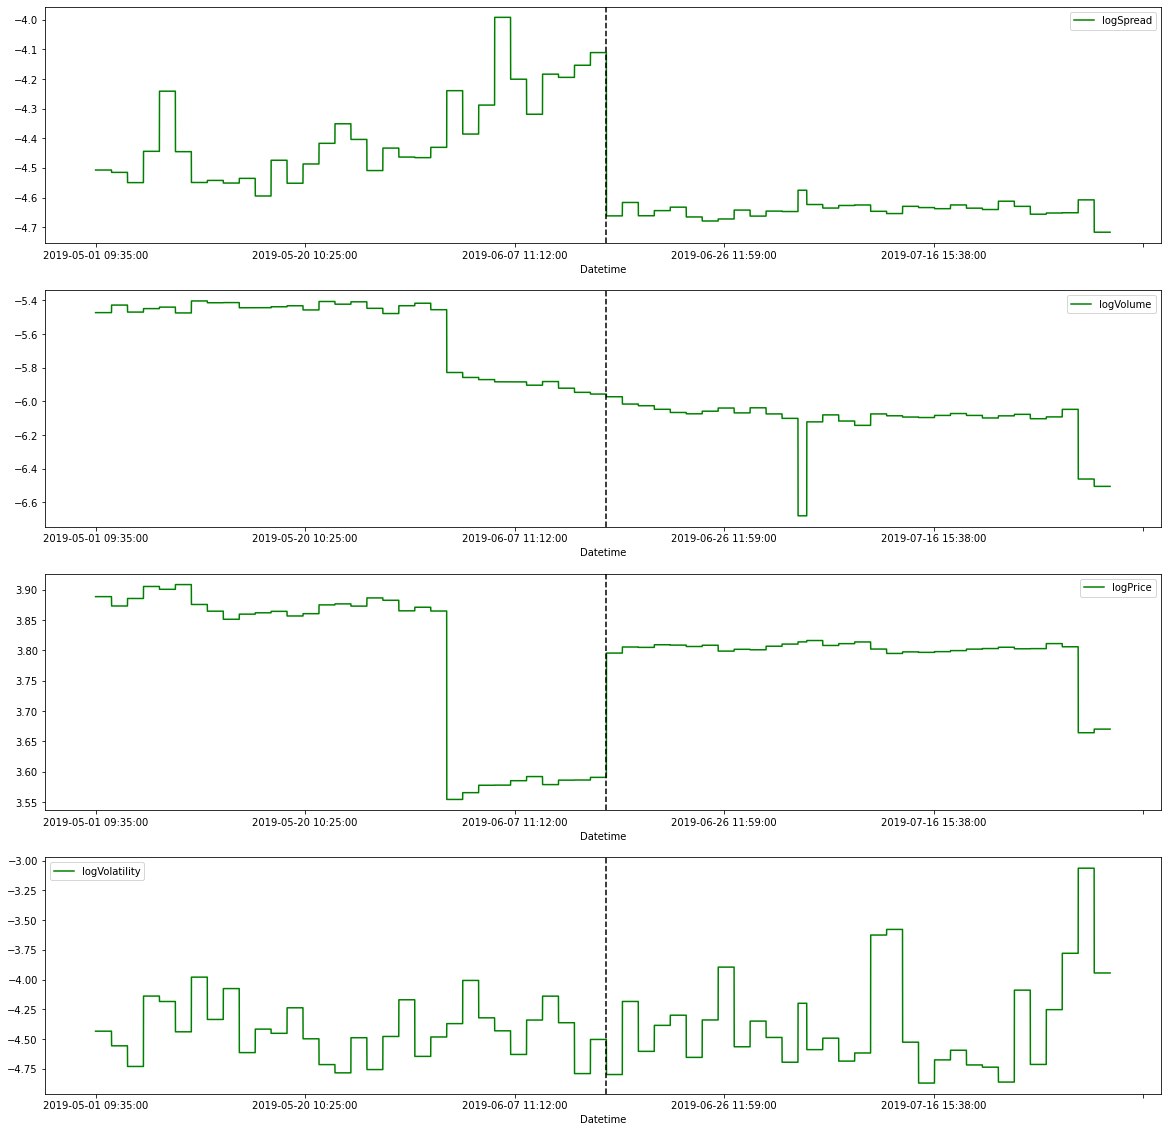

In [28]:
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroupDate.xs('PFE').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread',color='g')
a[0].axvline(PFE_DT, color='k', linestyle='--')
dfACQGroupDate.xs('PFE').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume',color='g')
a[1].axvline(PFE_DT, color='k', linestyle='--')
dfACQGroupDate.xs('PFE').plot(y='DailyLogPrice',ax=a[2],label='logPrice',color='g')
a[2].axvline(PFE_DT, color='k', linestyle='--')
dfACQGroupDate.xs('PFE').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='g')
a[3].axvline(PFE_DT, color='k', linestyle='--')

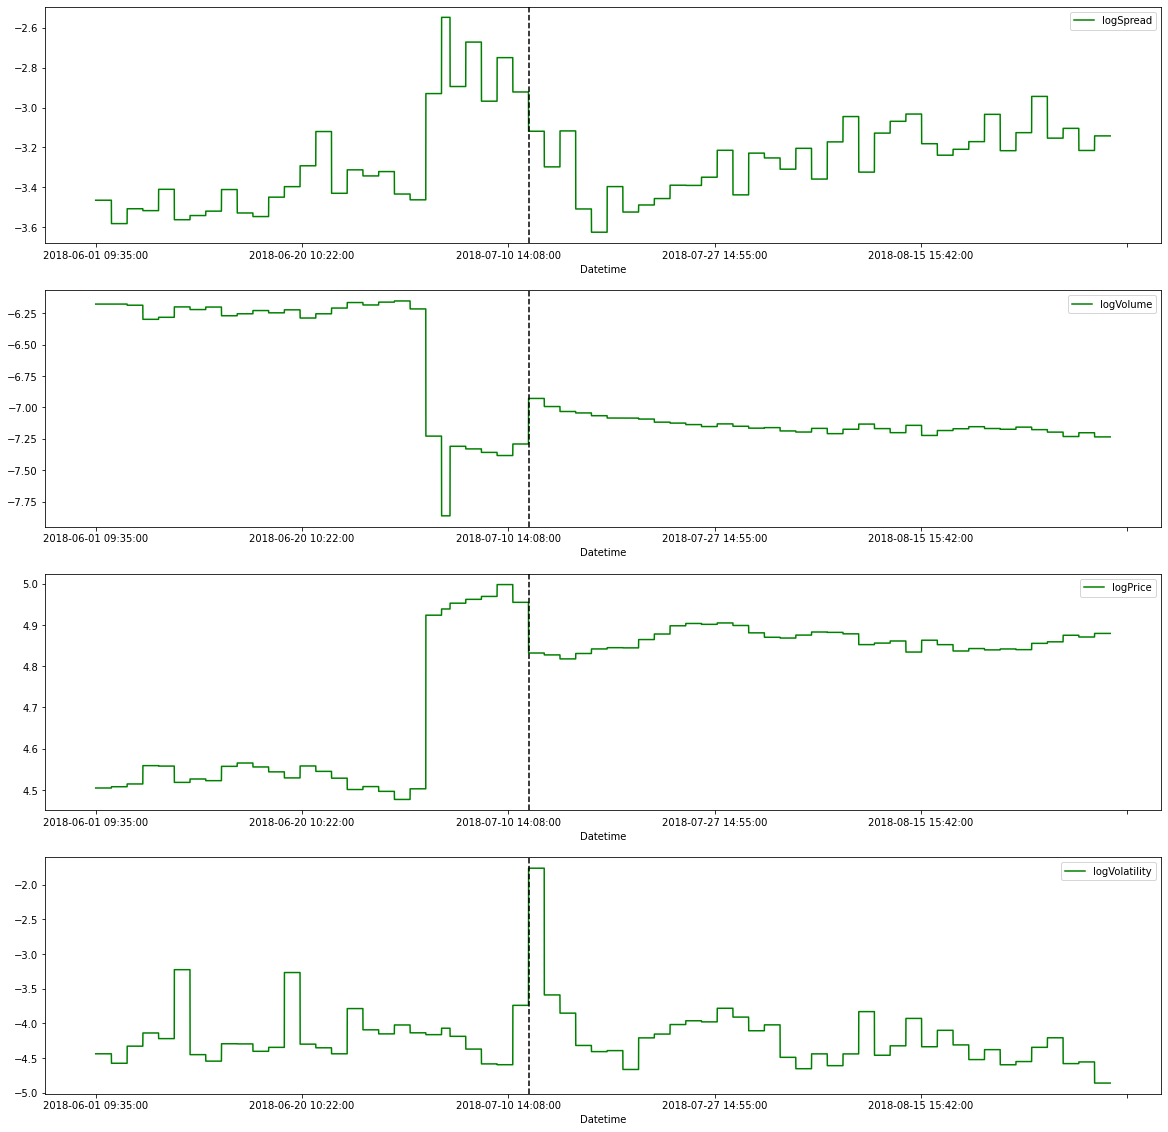

In [29]:
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroupDate.xs('AVGO').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread',color='g')
a[0].axvline(AVGO_DT, color='k', linestyle='--')
dfACQGroupDate.xs('AVGO').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume',color='g')
a[1].axvline(AVGO_DT, color='k', linestyle='--')
dfACQGroupDate.xs('AVGO').plot(y='DailyLogPrice',ax=a[2],label='logPrice',color='g')
a[2].axvline(AVGO_DT, color='k', linestyle='--')
dfACQGroupDate.xs('AVGO').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='g')
a[3].axvline(AVGO_DT, color='k', linestyle='--')

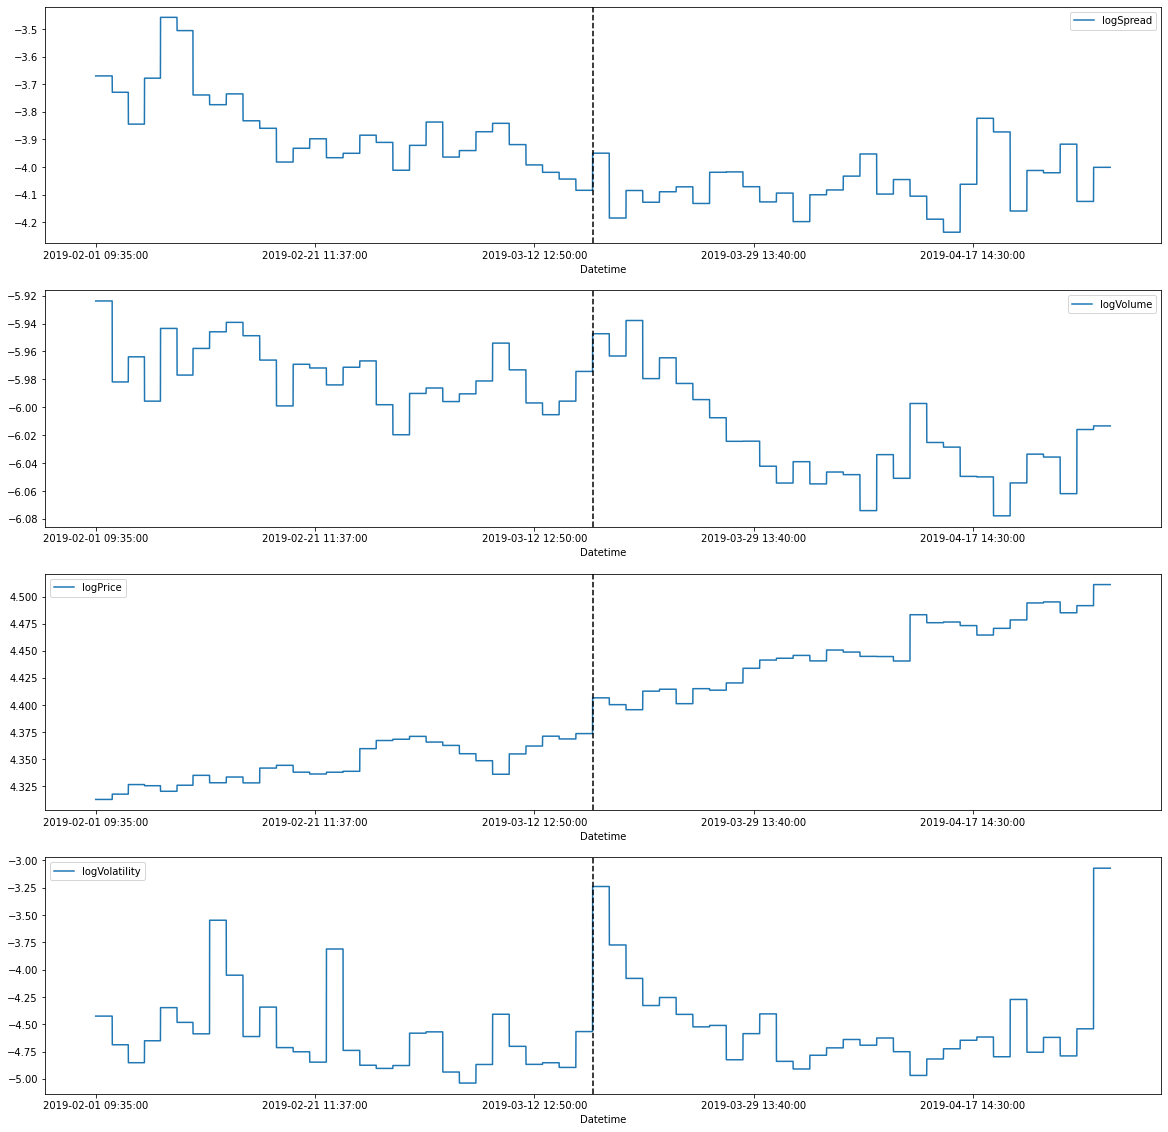

In [30]:
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroupDate.xs('FIS').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread')
a[0].axvline(FIS_DT, color='k', linestyle='--')
dfACQGroupDate.xs('FIS').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume')
a[1].axvline(FIS_DT, color='k', linestyle='--')
dfACQGroupDate.xs('FIS').plot(y='DailyLogPrice',ax=a[2],label='logPrice')
a[2].axvline(FIS_DT, color='k', linestyle='--')
dfACQGroupDate.xs('FIS').plot(y='logDayVolatility',ax=a[3],label='logVolatility')
a[3].axvline(FIS_DT, color='k', linestyle='--')

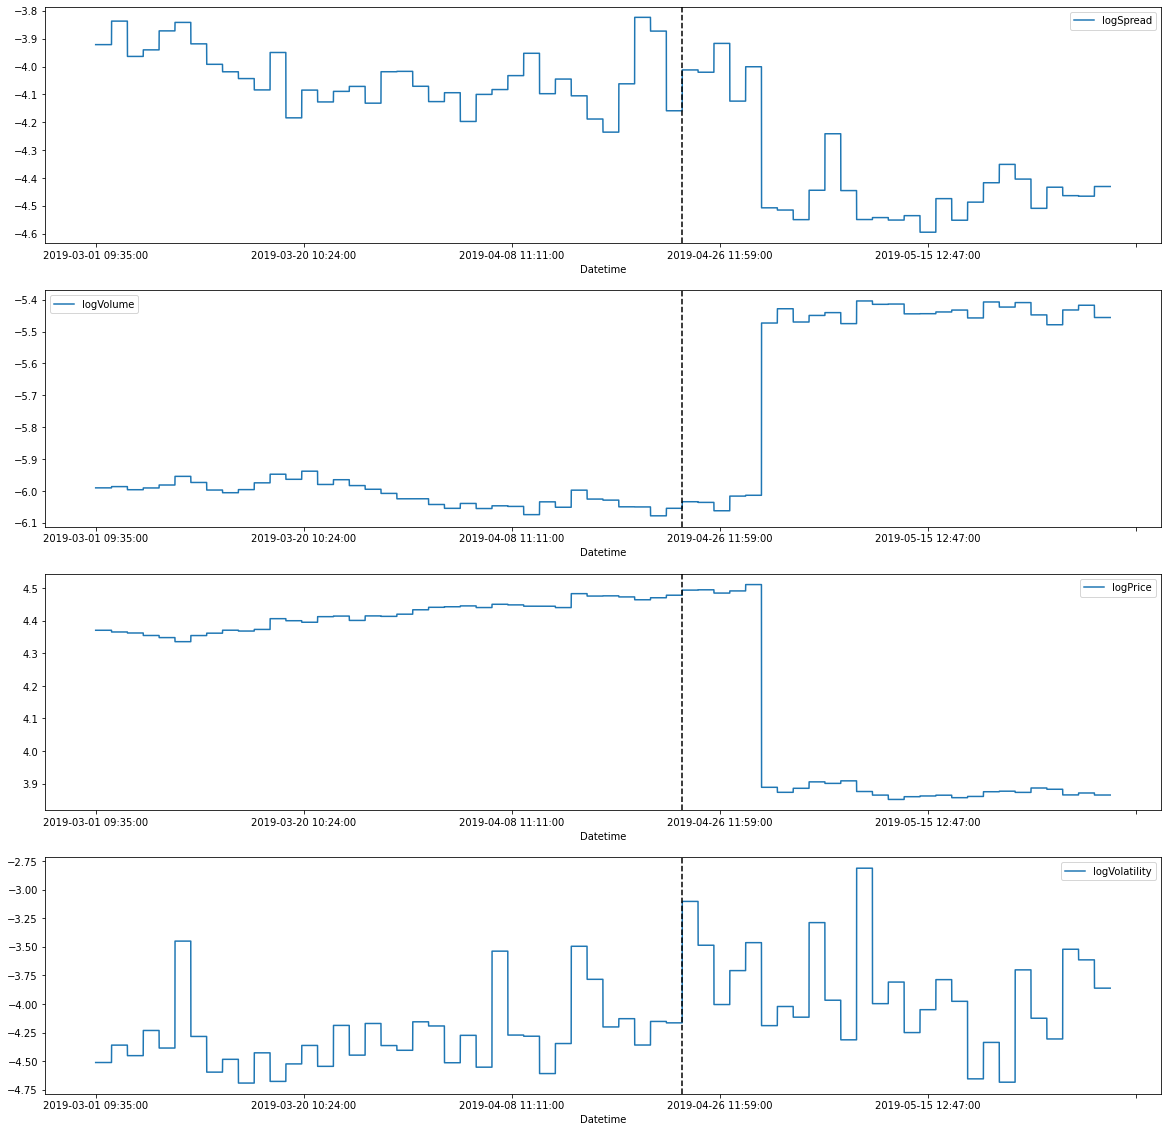

In [31]:
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroupDate.xs('OXY').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread')
a[0].axvline(OXY_DT, color='k', linestyle='--')
dfACQGroupDate.xs('OXY').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume')
a[1].axvline(OXY_DT, color='k', linestyle='--')
dfACQGroupDate.xs('OXY').plot(y='DailyLogPrice',ax=a[2],label='logPrice')
a[2].axvline(OXY_DT, color='k', linestyle='--')
dfACQGroupDate.xs('OXY').plot(y='logDayVolatility',ax=a[3],label='logVolatility')
a[3].axvline(OXY_DT, color='k', linestyle='--')

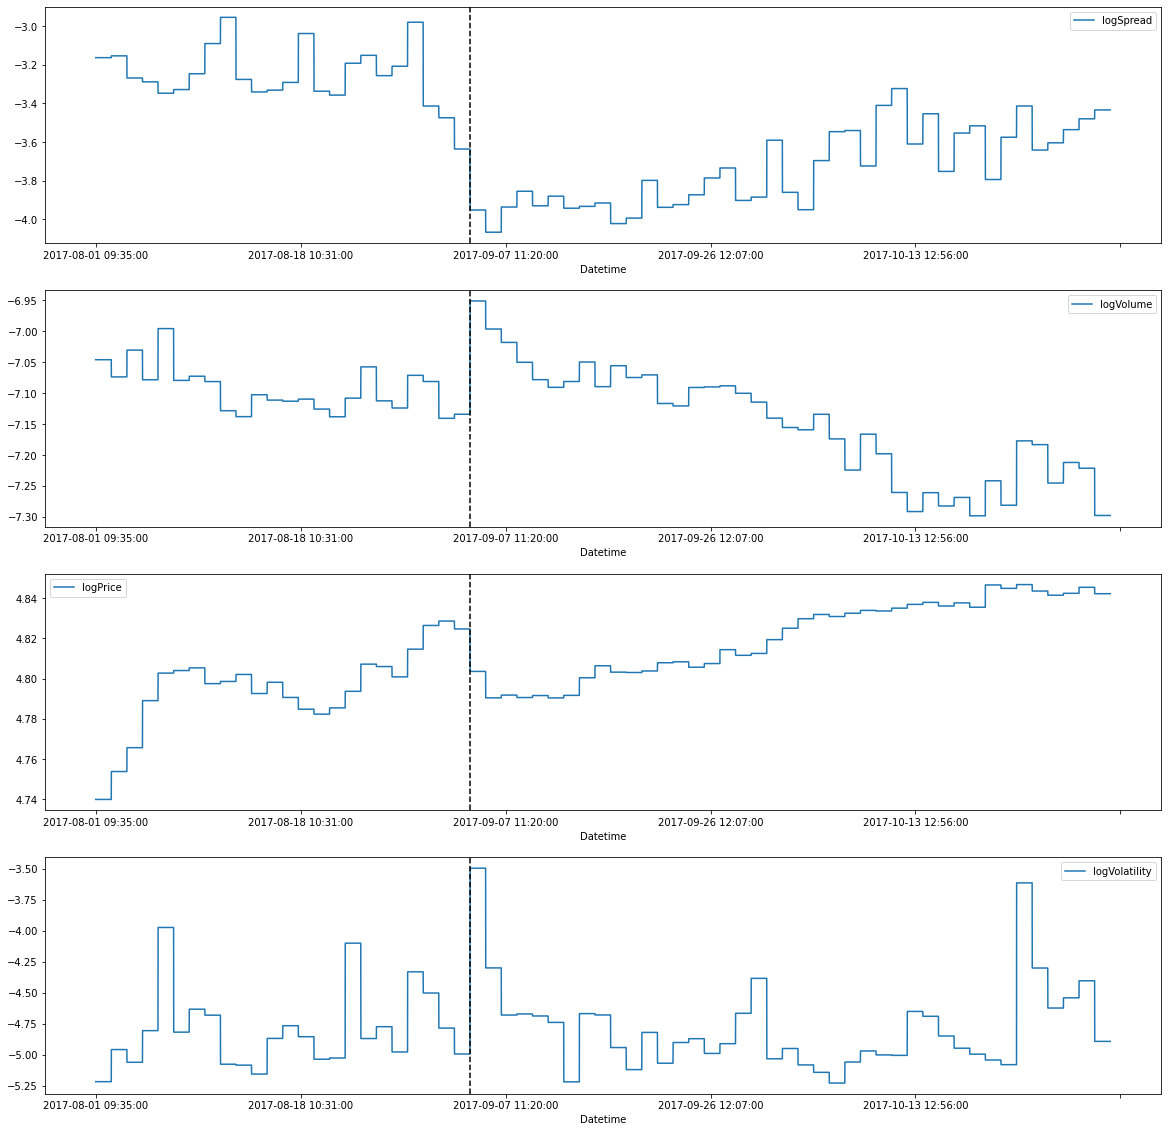

In [32]:
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroupDate.xs('UTX').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread')
a[0].axvline(UTX_DT, color='k', linestyle='--')
dfACQGroupDate.xs('UTX').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume')
a[1].axvline(UTX_DT, color='k', linestyle='--')
dfACQGroupDate.xs('UTX').plot(y='DailyLogPrice',ax=a[2],label='logPrice')
a[2].axvline(UTX_DT, color='k', linestyle='--')
dfACQGroupDate.xs('UTX').plot(y='logDayVolatility',ax=a[3],label='logVolatility')
a[3].axvline(UTX_DT, color='k', linestyle='--')

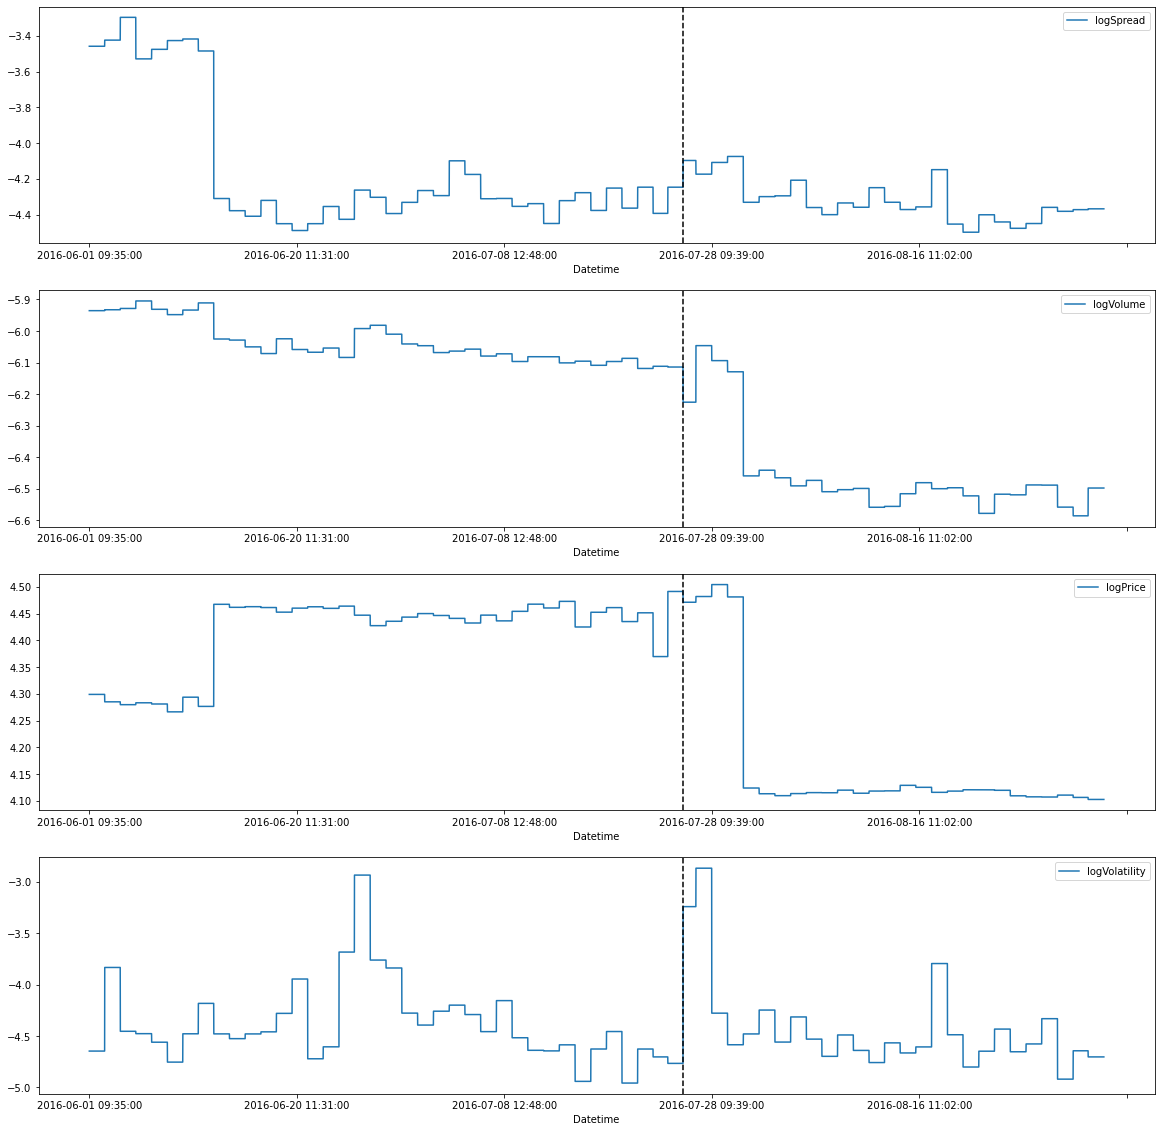

In [33]:
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroupDate.xs('ADI').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread')
a[0].axvline(ADI_DT, color='k', linestyle='--')
dfACQGroupDate.xs('ADI').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume')
a[1].axvline(ADI_DT, color='k', linestyle='--')
dfACQGroupDate.xs('ADI').plot(y='DailyLogPrice',ax=a[2],label='logPrice')
a[2].axvline(ADI_DT, color='k', linestyle='--')
dfACQGroupDate.xs('ADI').plot(y='logDayVolatility',ax=a[3],label='logVolatility')
a[3].axvline(ADI_DT, color='k', linestyle='--')

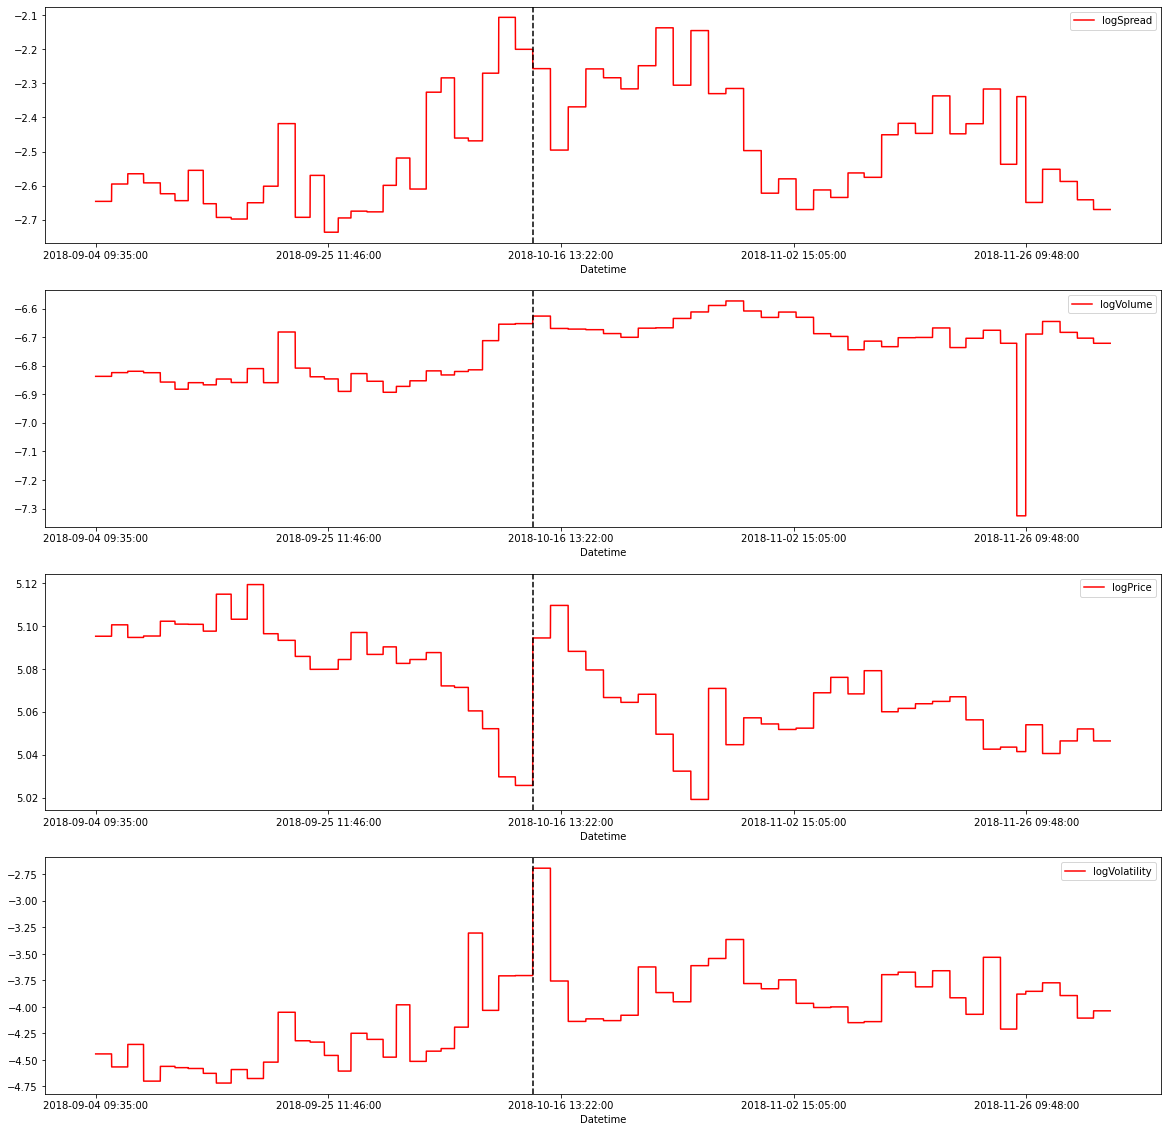

In [34]:
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroupDate.xs('HRS').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread',color='r')
a[0].axvline(HRS_DT, color='k', linestyle='--')
dfACQGroupDate.xs('HRS').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume',color='r')
a[1].axvline(HRS_DT, color='k', linestyle='--')
dfACQGroupDate.xs('HRS').plot(y='DailyLogPrice',ax=a[2],label='logPrice',color='r')
a[2].axvline(HRS_DT, color='k', linestyle='--')
dfACQGroupDate.xs('HRS').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='r')
a[3].axvline(HRS_DT, color='k', linestyle='--')

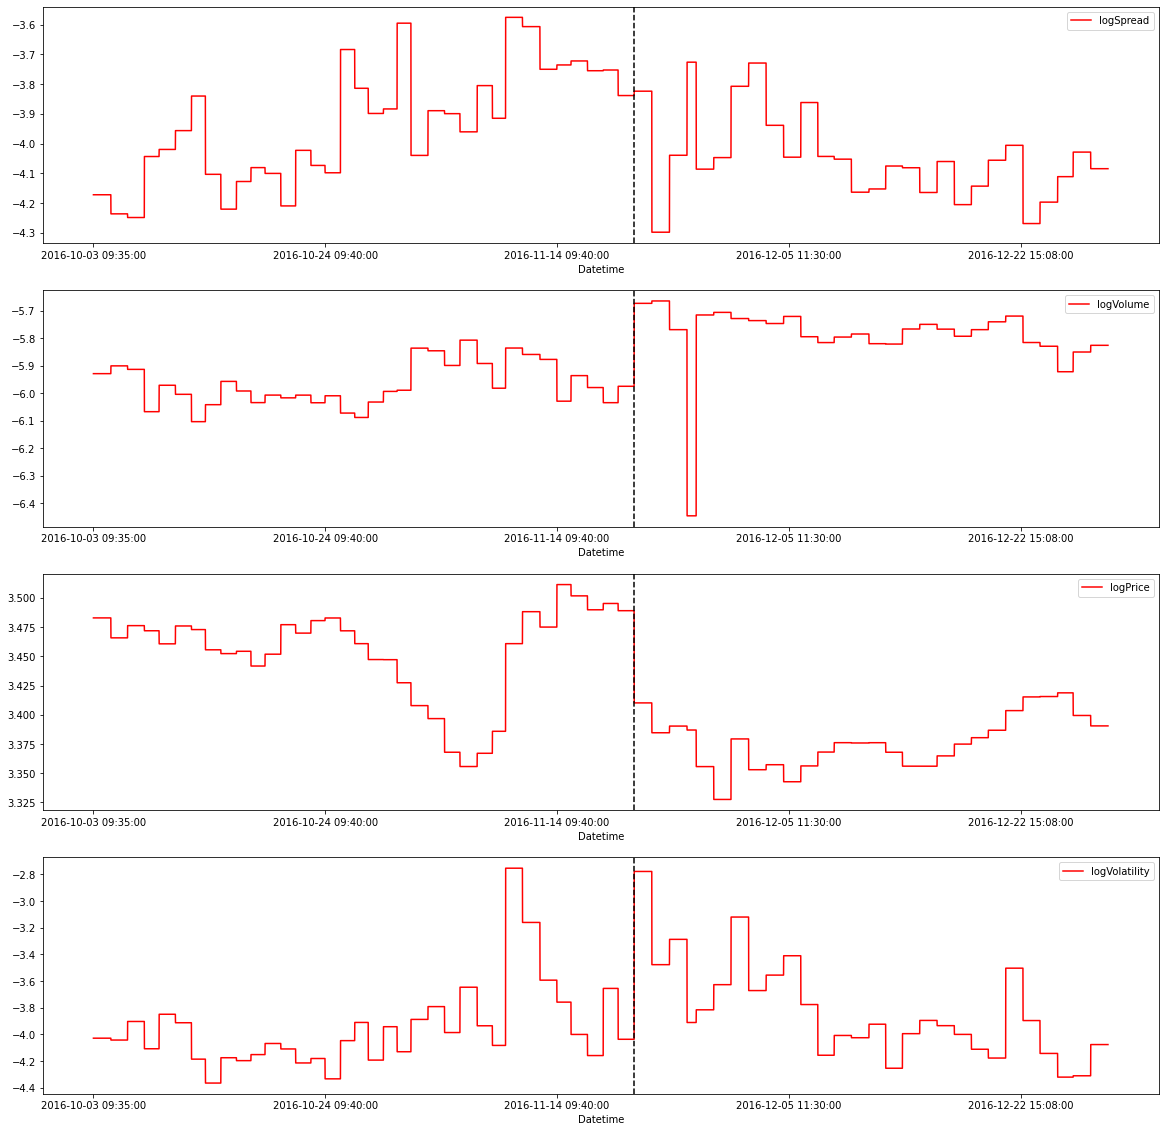

In [35]:
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroupDate.xs('SXL').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread',color='r')
a[0].axvline(SXL_DT, color='k', linestyle='--')
dfACQGroupDate.xs('SXL').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume',color='r')
a[1].axvline(SXL_DT, color='k', linestyle='--')
dfACQGroupDate.xs('SXL').plot(y='DailyLogPrice',ax=a[2],label='logPrice',color='r')
a[2].axvline(SXL_DT, color='k', linestyle='--')
dfACQGroupDate.xs('SXL').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='r')
a[3].axvline(SXL_DT, color='k', linestyle='--')

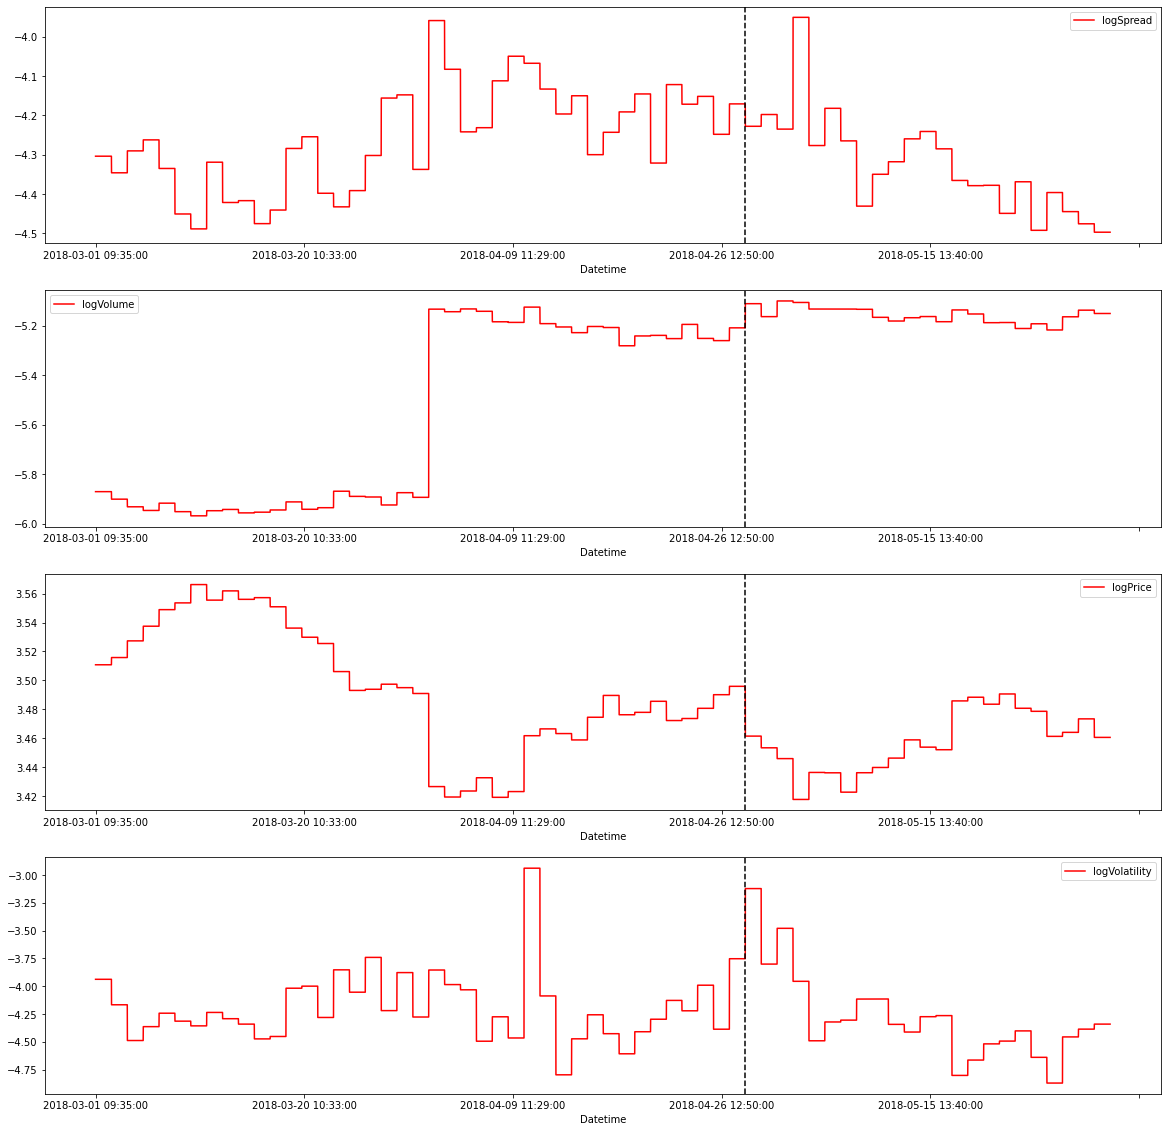

In [36]:
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroupDate.xs('TMUS').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread',color='r')
a[0].axvline(TMUS_DT, color='k', linestyle='--')
dfACQGroupDate.xs('TMUS').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume',color='r')
a[1].axvline(TMUS_DT, color='k', linestyle='--')
dfACQGroupDate.xs('TMUS').plot(y='DailyLogPrice',ax=a[2],label='logPrice',color='r')
a[2].axvline(TMUS_DT, color='k', linestyle='--')
dfACQGroupDate.xs('TMUS').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='r')
a[3].axvline(TMUS_DT, color='k', linestyle='--')

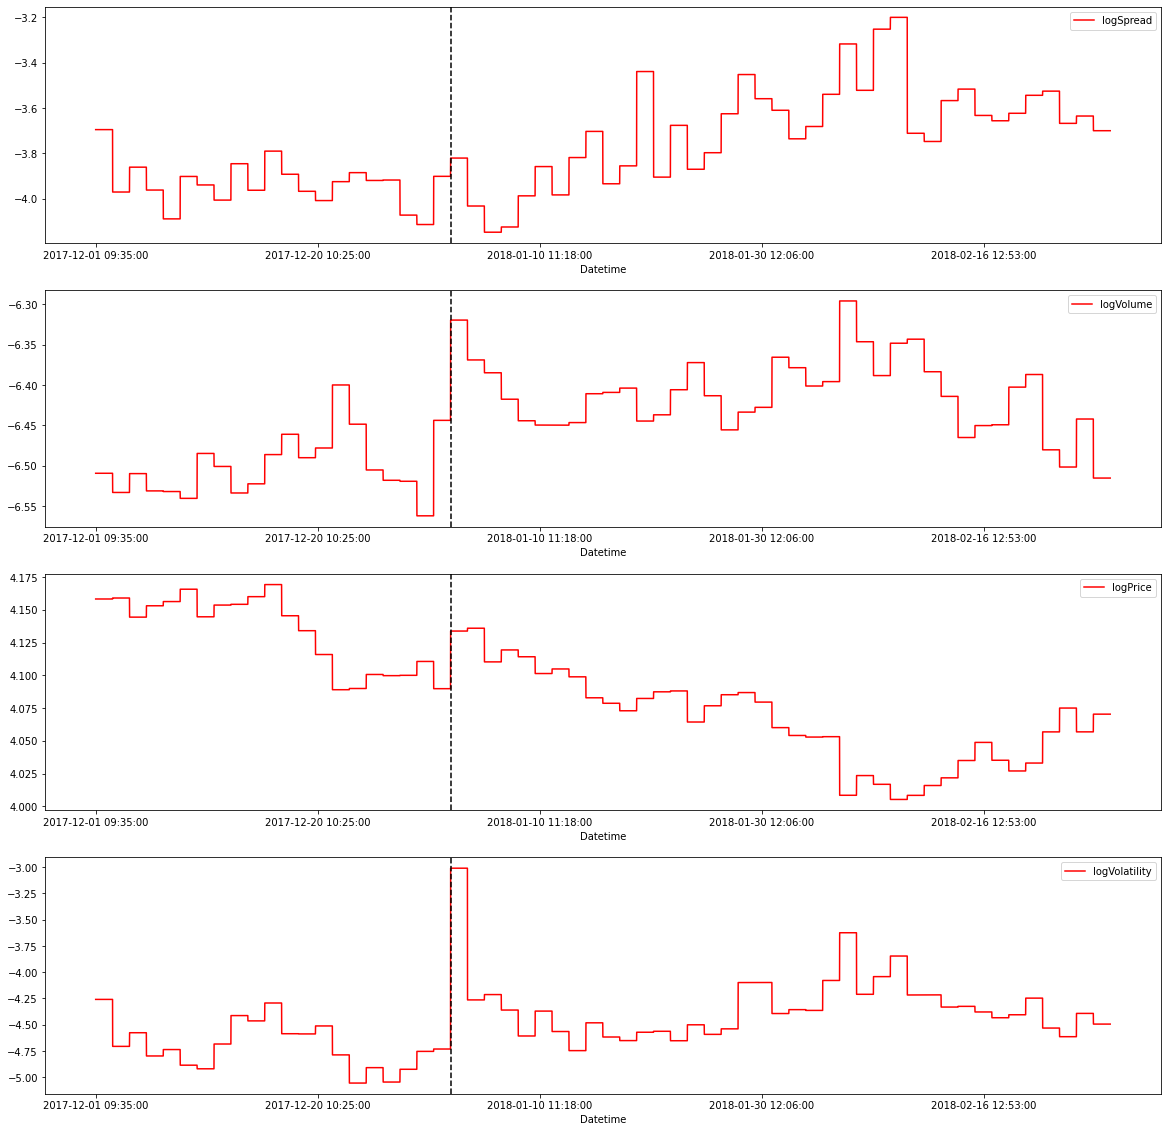

In [37]:
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroupDate.xs('D').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread',color='r')
a[0].axvline(D_DT, color='k', linestyle='--')
dfACQGroupDate.xs('D').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume',color='r')
a[1].axvline(D_DT, color='k', linestyle='--')
dfACQGroupDate.xs('D').plot(y='DailyLogPrice',ax=a[2],label='logPrice',color='r')
a[2].axvline(D_DT, color='k', linestyle='--')
dfACQGroupDate.xs('D').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='r')
a[3].axvline(D_DT, color='k', linestyle='--')

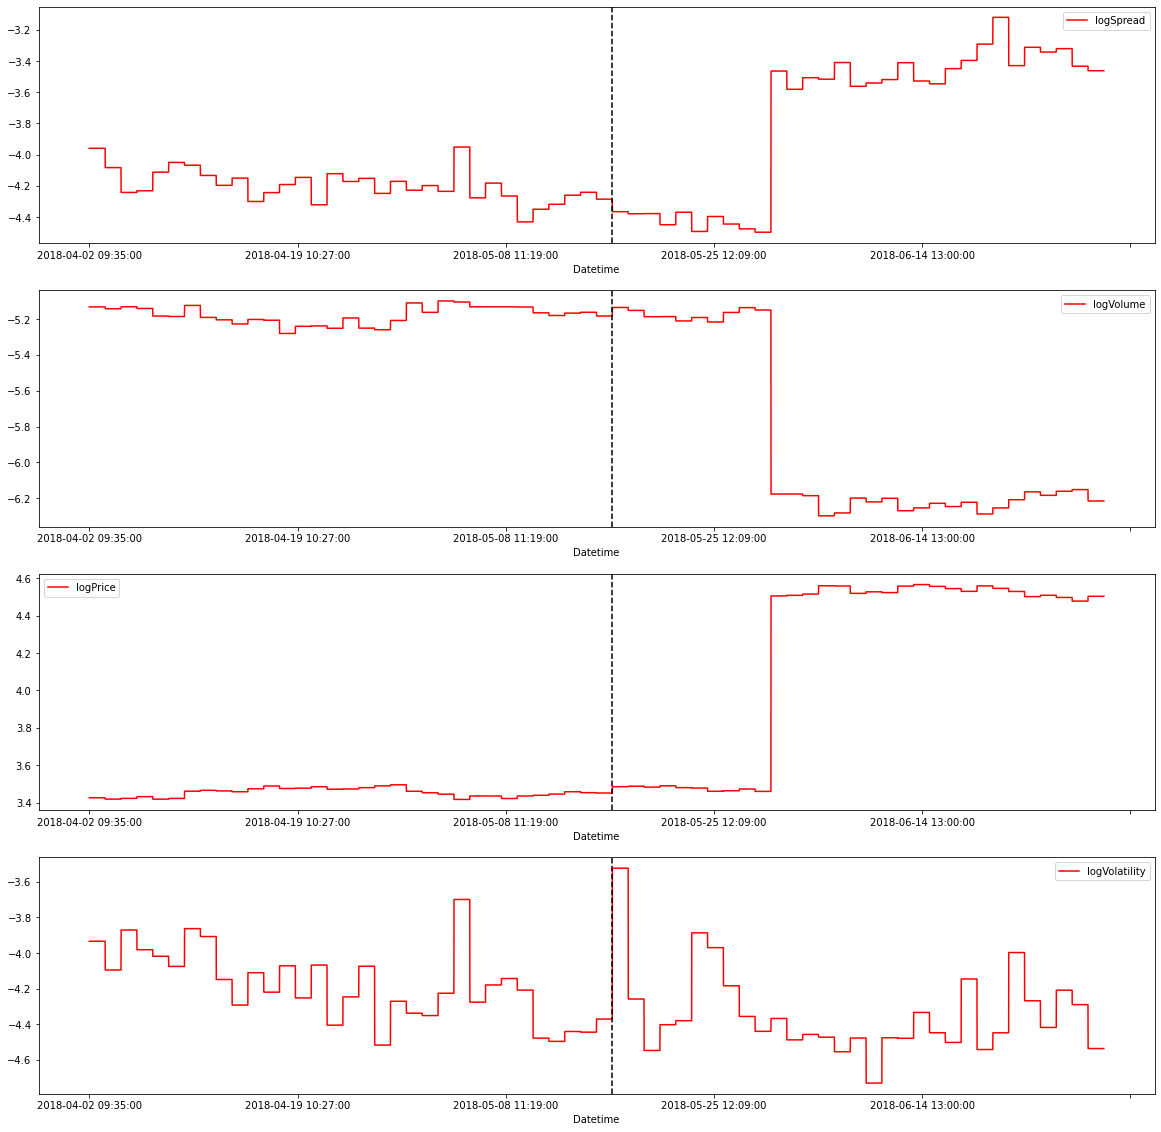

In [38]:
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroupDate.xs('WMB').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread',color='r')
a[0].axvline(WMB_DT, color='k', linestyle='--')
dfACQGroupDate.xs('WMB').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume',color='r')
a[1].axvline(WMB_DT, color='k', linestyle='--')
dfACQGroupDate.xs('WMB').plot(y='DailyLogPrice',ax=a[2],label='logPrice',color='r')
a[2].axvline(WMB_DT, color='k', linestyle='--')
dfACQGroupDate.xs('WMB').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='r')
a[3].axvline(WMB_DT, color='k', linestyle='--')

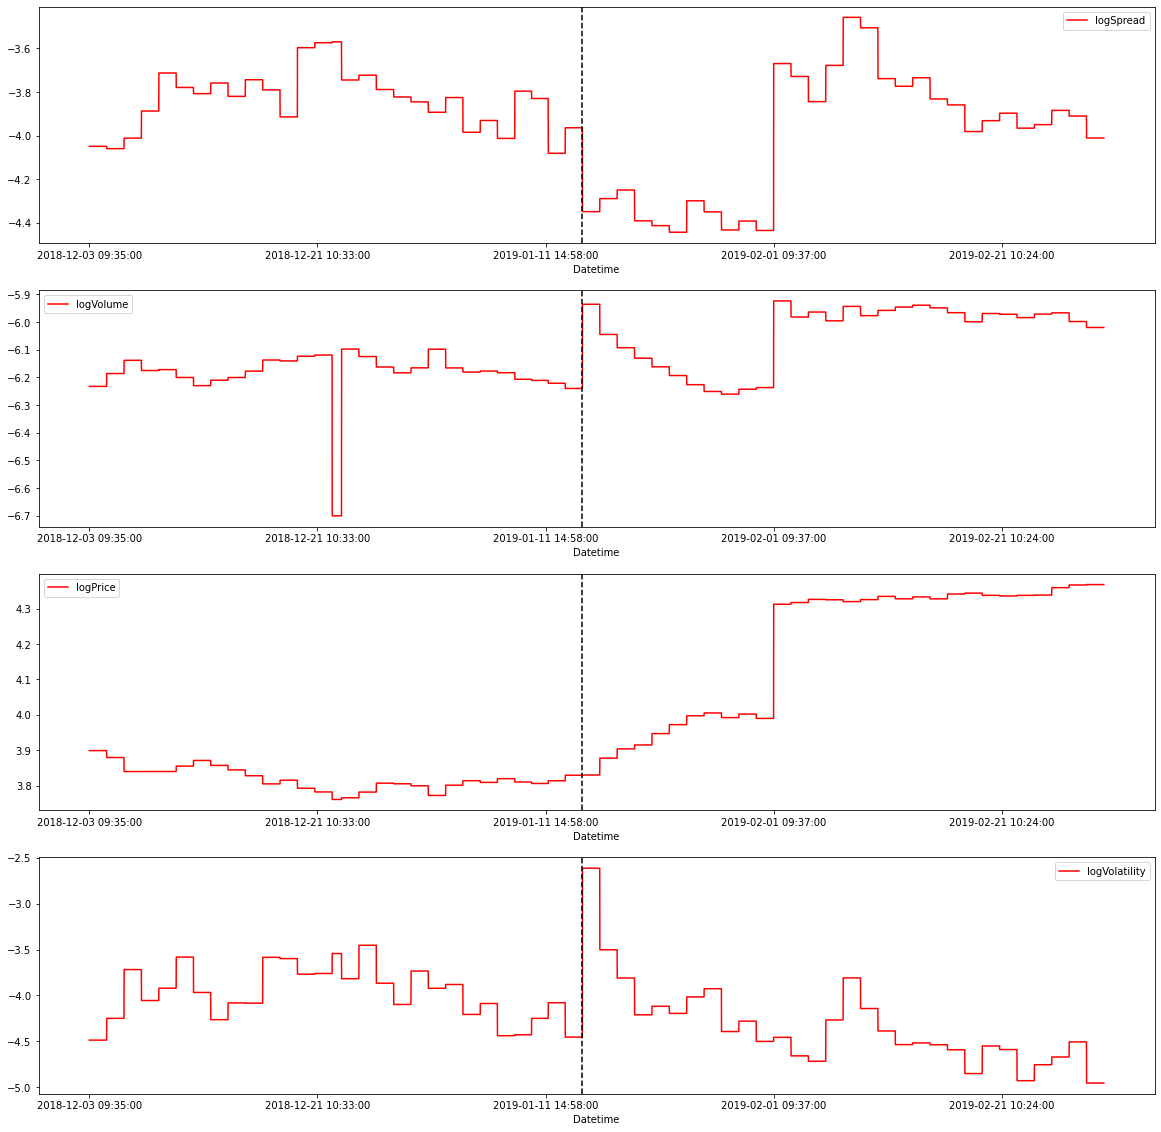

In [39]:
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroupDate.xs('FISV').plot(y='DailyLogOfSpread',ax=a[0],label='logSpread',color='r')
a[0].axvline(FISV_DT, color='k', linestyle='--')
dfACQGroupDate.xs('FISV').plot(y='DailyLogShareVolume',ax=a[1],label='logVolume',color='r')
a[1].axvline(FISV_DT, color='k', linestyle='--')
dfACQGroupDate.xs('FISV').plot(y='DailyLogPrice',ax=a[2],label='logPrice',color='r')
a[2].axvline(FISV_DT, color='k', linestyle='--')
dfACQGroupDate.xs('FISV').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='r')
a[3].axvline(FISV_DT, color='k', linestyle='--')